# ANOVA 분산검정
분산검정 ANOVA 검정 후 평균검정T-test 진행 


<span style="color:skyblue">**등분산검정으로 두 독립변수 분산 동일성 검증 (ANOVA)**</span><br>
귀무가설 H0 집단간 분산 같다 -> 등분산 -> Student's t-test <br>
대립가설 H1 집단간 분산 다르다 -> 이분산 -> Welch's t-test


In [15]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'malgun gothic'
from sklearn.metrics import accuracy_score, log_loss, plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from scipy import stats
from statsmodels.multivariate.manova import MANOVA

In [16]:
df_full = pd.read_csv('..\..\..\Data\데이터정리중\재무변수_부도사유_Final.csv', index_col=0)

In [17]:
df_full['부도'].value_counts()

1.0    26915
0.0      442
Name: 부도, dtype: int64

In [18]:
df_full = df_full.fillna(0)
df_full

,회사명,거래소코드,회계년도,소속코드,상장폐지일,감사의견코드,자산총계(요약),유동자산(요약),당좌자산(요약),현금 및 현금성자산(요약),...,기업가치(EV),EBITDA,EBITDA/매출액,EBITDA/금융비용,EBITDA/평균발행주식수,EV/EBITDA,년,key,공시제목,부도
0,(주)CMG제약,58820.0,2000/12,5.0,0,UQ,28990.0,21169.0,10541.0,4330.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2001.0,588202001,0,1.0
1,(주)CMG제약,58820.0,2001/12,5.0,0,UQ,20908.0,16359.0,2307.0,1829.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2002.0,588202002,0,1.0
2,(주)CMG제약,58820.0,2002/12,5.0,0,UQ,15401.0,9880.0,1436.0,355.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2003.0,588202003,0,1.0
3,(주)CMG제약,58820.0,2003/12,5.0,0,UQ,11063.0,8534.0,1083.0,2.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2004.0,588202004,0,1.0
4,(주)CMG제약,58820.0,2004/12,5.0,0,UQ,5179.0,3893.0,445.0,11.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2005.0,588202005,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,흥구석유(주),24060.0,2016/12,5.0,0,UQ,79137.0,14794.0,12274.0,1440.0,...,55934.79,1348.52,0.94,10.71,89.90,41.48,2017.0,240602017,0,1.0
27353,흥구석유(주),24060.0,2017/12,5.0,0,UQ,79912.0,15880.0,13124.0,1588.0,...,46036.63,1147.56,0.74,9.02,76.50,40.12,2018.0,240602018,0,1.0
27354,흥구석유(주),24060.0,2018/12,5.0,0,UQ,75206.0,12515.0,11029.0,4017.0,...,36557.57,1451.79,0.87,16.83,96.79,25.18,2019.0,240602019,0,1.0
27355,흥구석유(주),24060.0,2019/12,5.0,0,UQ,83661.0,22620.0,19701.0,2318.0,...,78081.78,1009.25,0.67,507.93,67.28,77.37,2020.0,240602020,0,1.0


In [19]:
numerical_feats = df_full.dtypes[df_full.dtypes != "object"].index.tolist()
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_full.dtypes[df_full.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  266
Number of Categorical features:  5


In [20]:
categorical_feats

['회사명', '회계년도', '상장폐지일', '감사의견코드', '공시제목']

In [21]:
df = df_full.iloc[:, 6:267]

In [22]:
df['부도'] = df_full['부도']

In [23]:
#df 부도칼럼 있음 df_ 부도칼럼 없음
df_=df
df_ = df.drop(columns=['부도'])

In [24]:
df_

,자산총계(요약),유동자산(요약),당좌자산(요약),현금 및 현금성자산(요약),단기투자자산(요약),단기예금(요약),단기매매증권(요약),단기대여금(요약),기타단기투자자산(요약),매출채권(요약),...,PCR(Price cash-flow ratio)(최고),PCR(Price cash-flow ratio)(최저),PSR(Price sales ratio)(최고),PSR(Price sales ratio)(최저),기업가치(EV),EBITDA,EBITDA/매출액,EBITDA/금융비용,EBITDA/평균발행주식수,EV/EBITDA
0,28990.0,21169.0,10541.0,4330.0,4552.0,4539.0,1.0,13.0,0.0,786.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,20908.0,16359.0,2307.0,1829.0,18.0,0.0,6.0,13.0,0.0,14.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,15401.0,9880.0,1436.0,355.0,246.0,240.0,6.0,0.0,0.0,26.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,11063.0,8534.0,1083.0,2.0,381.0,380.0,0.0,0.0,1.0,72.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5179.0,3893.0,445.0,11.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,79137.0,14794.0,12274.0,1440.0,5065.0,0.0,0.0,0.0,5065.0,5158.0,...,55.71,35.62,0.43,0.28,55934.79,1348.52,0.94,10.71,89.90,41.48
27353,79912.0,15880.0,13124.0,1588.0,5058.0,0.0,0.0,0.0,5058.0,6315.0,...,33.70,24.31,0.34,0.24,46036.63,1147.56,0.74,9.02,76.50,40.12
27354,75206.0,12515.0,11029.0,4017.0,5.0,0.0,0.0,0.0,5.0,4403.0,...,13.22,7.82,0.40,0.24,36557.57,1451.79,0.87,16.83,96.79,25.18
27355,83661.0,22620.0,19701.0,2318.0,11472.0,0.0,0.0,0.0,11472.0,5161.0,...,176.30,51.31,0.86,0.25,78081.78,1009.25,0.67,507.93,67.28,77.37


## 분산 검정 (ANOVA)
<br>
등분산성: 분산분석(ANOVA)을 통해 서로 다른 두개 이상의 집단을 비교하고자 할때, <br>
기본적으로 해당 집단들이 만족해야되는 조건 중 한가지로 분산이 같음을 의미<br>

<span style="color:skyblue">**Levene 등분산검정으로 두 독립변수 분산 동일성 검증 (ANOVA)**</span><br>
귀무가설 H0 집단간 분산 같다 -> 등분산 -> Student's t-test <br>
대립가설 H1 집단간 분산 다르다 -> 이분산 -> Welch's t-test

### two way ANOVA F검정 이원분산분석
해당 데이터는 종속변수(y)가 '부도' 하나임으로 단일변량판별분석 중 다수의 독립변수로 분석하는 이원분산분석 시행<br><br>
F검정 시 특수문자(_제외)와 숫자가 칼럼 첫번째 문자열이면 에러떠서 _로 변경 필요<br>
<br>
p-value 0.05 이하이면 귀무가설 기각 대립가설 채택하여 **이분산** t-test 진행<br>
p-value 0.05 이상이면 귀무가설 채택 대립가설 기각하여 **등분산** t-test 진행<br>

In [25]:
from pandas import DataFrame
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [26]:
#F검정 시 특수문자(_제외)와 숫자가 칼럼 첫번째 문자열이면 에러떠서 _로 변경 필요
df.columns[14:50]

Index(['제품(요약)', '반제품(요약)', '재공품(요약)', '원재료(요약)', '기타재고자산(요약)', '임대주택자산(요약)',
       '비유동자산(요약)', '투자자산(요약)', '*장기금융상품(요약)', '*투자유가증권(장기투자증권)(요약)',
       '유형자산(요약)', '토지', '건설중인자산', '건물', '기계장치', '차량운반구', '렌탈자산', '설비자산',
       '무형자산(요약)', '기타비유동자산(요약)', '이연자산(요약)', '부채총계(요약)', '유동부채(요약)',
       '매입채무(요약)', '단기차입금(요약)', '유동성장기부채(요약)', '기타유동부채(요약)', '비유동부채(요약)',
       '사채(요약)', '장기차입금(요약)', '제충당금(요약)', '기타비유동부채(요약)', '이연부채(요약)',
       '자본총계(요약)', '자본금(요약)', '자본잉여금(요약)'],
      dtype='object')

In [27]:
#특수문자 _로 변경
col_list = list(df.columns)

import re
for k in range(len(col_list)):
    filtered_col = re.sub(r'[^\d\w]', '_',col_list[k])
    col_list[k] = filtered_col

df.columns = col_list

In [28]:
#첫글자가 숫자인 칼럼 _로 변경
col_list = list(df.columns)

for i in range(len(col_list)):

    if col_list[i][0] == '1':
        col_list[i] = '_'+ col_list[i]
    else :
        pass
    
df.columns = col_list

In [29]:
#칼럼 전체보기
pd.set_option('display.max_seq_items', None)

In [30]:
df.columns

Index(['자산총계_요약_', '유동자산_요약_', '당좌자산_요약_', '현금_및_현금성자산_요약_', '단기투자자산_요약_',
       '단기예금_요약_', '단기매매증권_요약_', '단기대여금_요약_', '기타단기투자자산_요약_', '매출채권_요약_',
       '_할인어음_또는_배서어음_요약_', '기타당좌자산_요약_', '재고자산_요약_', '상품_요약_', '제품_요약_',
       '반제품_요약_', '재공품_요약_', '원재료_요약_', '기타재고자산_요약_', '임대주택자산_요약_',
       '비유동자산_요약_', '투자자산_요약_', '_장기금융상품_요약_', '_투자유가증권_장기투자증권__요약_',
       '유형자산_요약_', '토지', '건설중인자산', '건물', '기계장치', '차량운반구', '렌탈자산', '설비자산',
       '무형자산_요약_', '기타비유동자산_요약_', '이연자산_요약_', '부채총계_요약_', '유동부채_요약_',
       '매입채무_요약_', '단기차입금_요약_', '유동성장기부채_요약_', '기타유동부채_요약_', '비유동부채_요약_',
       '사채_요약_', '장기차입금_요약_', '제충당금_요약_', '기타비유동부채_요약_', '이연부채_요약_',
       '자본총계_요약_', '자본금_요약_', '자본잉여금_요약_', '자본조정_요약_', '기타포괄손익누계액_요약_',
       '이익잉여금_요약_', '_미처분이익잉여금_및_차기이월미처분이익잉여금_요약_', '_당기순이익_요약_',
       '부채와자본총계_요약_', '매출액_요약_', '매출원가_요약_', '매출총이익_요약_', '판매비와_관리비_요약_', '급료',
       '퇴직급여_요약_', '복리후생비_요약_', '세금과공과_요약_', '임차료_요약_', '감가상각비', '연구비',
       '기타_판매비와_관리비_요약_', '영업이익_요약_', '영업외수익_요약_', '이자수익_요약_',

In [31]:
# 독립변수 +로 연결지어줌
'+'.join(df.columns)

'자산총계_요약_+유동자산_요약_+당좌자산_요약_+현금_및_현금성자산_요약_+단기투자자산_요약_+단기예금_요약_+단기매매증권_요약_+단기대여금_요약_+기타단기투자자산_요약_+매출채권_요약_+_할인어음_또는_배서어음_요약_+기타당좌자산_요약_+재고자산_요약_+상품_요약_+제품_요약_+반제품_요약_+재공품_요약_+원재료_요약_+기타재고자산_요약_+임대주택자산_요약_+비유동자산_요약_+투자자산_요약_+_장기금융상품_요약_+_투자유가증권_장기투자증권__요약_+유형자산_요약_+토지+건설중인자산+건물+기계장치+차량운반구+렌탈자산+설비자산+무형자산_요약_+기타비유동자산_요약_+이연자산_요약_+부채총계_요약_+유동부채_요약_+매입채무_요약_+단기차입금_요약_+유동성장기부채_요약_+기타유동부채_요약_+비유동부채_요약_+사채_요약_+장기차입금_요약_+제충당금_요약_+기타비유동부채_요약_+이연부채_요약_+자본총계_요약_+자본금_요약_+자본잉여금_요약_+자본조정_요약_+기타포괄손익누계액_요약_+이익잉여금_요약_+_미처분이익잉여금_및_차기이월미처분이익잉여금_요약_+_당기순이익_요약_+부채와자본총계_요약_+매출액_요약_+매출원가_요약_+매출총이익_요약_+판매비와_관리비_요약_+급료+퇴직급여_요약_+복리후생비_요약_+세금과공과_요약_+임차료_요약_+감가상각비+연구비+기타_판매비와_관리비_요약_+영업이익_요약_+영업외수익_요약_+이자수익_요약_+배당금수익_요약_+외환차익_요약_+외화환산이익_요약_+지분법이익_요약_+기타영업외수익_요약_+영업외비용_요약_+이자비용_요약_+외환차손_요약_+외화환산손실_요약_+지분법손실_요약_+기타영업외비용_요약_+법인세비용차감전_계속사업_손익_요약_+_계속사업손익_법인세비용_요약_+계속사업이익_요약_+중단사업이익_요약_+_법인세효과_요약_+당기순이익_요약_+주당계속사업이익_요약_+주당순이익_요약_+희석화주당계속사업이익_요약_+희석화주당순이익_요약_+CPA수정후_당기순이익_요약_+_주당경상이익_2007년_이전_발생__요약_+_희석화주당경상이익_2007년_이전_

In [32]:
#(종속변수 ~ 독립변수1 + 독립변수2 + ... + 독립변수n)
factor = "부도 ~ 자산총계_요약_+유동자산_요약_+당좌자산_요약_+현금_및_현금성자산_요약_+단기투자자산_요약_+단기예금_요약_+단기매매증권_요약_+단기대여금_요약_+기타단기투자자산_요약_+매출채권_요약_+_할인어음_또는_배서어음_요약_+기타당좌자산_요약_+재고자산_요약_+상품_요약_+제품_요약_+반제품_요약_+재공품_요약_+원재료_요약_+기타재고자산_요약_+임대주택자산_요약_+비유동자산_요약_+투자자산_요약_+_장기금융상품_요약_+_투자유가증권_장기투자증권__요약_+유형자산_요약_+토지+건설중인자산+건물+기계장치+차량운반구+렌탈자산+설비자산+무형자산_요약_+기타비유동자산_요약_+이연자산_요약_+부채총계_요약_+유동부채_요약_+매입채무_요약_+단기차입금_요약_+유동성장기부채_요약_+기타유동부채_요약_+비유동부채_요약_+사채_요약_+장기차입금_요약_+제충당금_요약_+기타비유동부채_요약_+이연부채_요약_+자본총계_요약_+자본금_요약_+자본잉여금_요약_+자본조정_요약_+기타포괄손익누계액_요약_+이익잉여금_요약_+_미처분이익잉여금_및_차기이월미처분이익잉여금_요약_+_당기순이익_요약_+부채와자본총계_요약_+매출액_요약_+매출원가_요약_+매출총이익_요약_+판매비와_관리비_요약_+급료+퇴직급여_요약_+복리후생비_요약_+세금과공과_요약_+임차료_요약_+감가상각비+연구비+기타_판매비와_관리비_요약_+영업이익_요약_+영업외수익_요약_+이자수익_요약_+배당금수익_요약_+외환차익_요약_+외화환산이익_요약_+지분법이익_요약_+기타영업외수익_요약_+영업외비용_요약_+이자비용_요약_+외환차손_요약_+외화환산손실_요약_+지분법손실_요약_+기타영업외비용_요약_+법인세비용차감전_계속사업_손익_요약_+_계속사업손익_법인세비용_요약_+계속사업이익_요약_+중단사업이익_요약_+_법인세효과_요약_+당기순이익_요약_+주당계속사업이익_요약_+주당순이익_요약_+희석화주당계속사업이익_요약_+희석화주당순이익_요약_+CPA수정후_당기순이익_요약_+_주당경상이익_2007년_이전_발생__요약_+_희석화주당경상이익_2007년_이전_발생__요약_+총자본증가율+유형자산증가율+유동자산증가율+영업이익증가율+경상이익증가율__2007년_이전_발생_+순이익증가율+재고자산증가율+자기자본증가율+매출액증가율+종업원1인당_부가가치증가율+종업원수증가율+비유동자산증가율+종업원1인당_매출액증가율+종업원1인당_인건비증가율+매출액총이익률+매출액영업이익률+매출액경상이익률__2007년_이전_발생_+매출액순이익률+총자본사업이익률+총자본영업이익률+총자본경상이익률__2007년_이전_발생_+총자본순이익률+자기자본영업이익률+자기자본경상이익률__2007년_이전_발생_+자기자본순이익률+자본금영업이익률+자본금경상이익률__2007년_이전_발생_+자본금순이익률+조세_대_조세차감전순이익률+기업경상이익률__2007년_이전_발생_+투자수익률__2007년_이전_발생_+기업순이익률+경영자본영업이익률+경영자본순이익률+매출원가_대_매출액비율+영업비율+영업외손익률+금융비용부담률+외환이익_대_매출액비율+광고선전비_대_매출액비율+수지비율+인건비_대_총비용비율+조세공과_대_총비용비율+금융비용_대_총비용비율+감가상각비_대_총비용비율+감가상각률+누적감가상각률+이자부담률+지급이자율+차입금평균이자율+사내유보율+사내유보_대_자기자본비율+적립금비율_재정비율_+평균배당률+자기자본배당률+배당성향+_1주당매출액+EPS_Earning_Per_Share_+_1주당경상이익__2007년_이전_발생_+CPS_Cash_flow_Per_Share_+BPS_Book_value_Per_Share_+유보율+R___D_투자효율+_1주당영업이익+유동자산구성비율+재고자산_대_유동자산비율+유동자산_대_비유동자산비율+당좌자산구성비율+비유동자산구성비율+자기자본구성비율+타인자본구성비율+자기자본배율+비유동비율+비유동장기적합률+유동비율+당좌비율+현금비율+원재료비율+매출채권비율+재고자산_대_순운전자본비율+매출채권_대_매입채무비율+매출채권_대_상+매입채무_대_재고자산비율+부채비율+유동부채비율+단기차입금_대_총차입금비율+비유동부채비율+비유동부채_대_순운전자본비율+순운전자본비율+차입금의존도+차입금비율+이자보상배율_이자비용_+이자보상배율_순금융비용_+유보액대비율+유보액_대_납입자본배율+유동자산집중도+비유동자산집중도+투자집중도+CASH_FLOW_대_부채비율+CASH_FLOW_대_차입금비율+CASH_FLOW_대_총자본비율+CASH_FLOW_대_매출액비율+영업이익대비이자보상배율+총자본회전률+경영자본회전률+자기자본회전률+자본금회전률+타인자본회전률+매입채무회전률+매입채무회전기간+유동자산회전률+당좌자산회전률+재고자산회전률+재고자산회전기간+상품+원+재공품회전률+매출채권회전률+매출채권회전기간+비유동자산회전률+유형자산회전율+순운전자본회전률+운전자본회전률+_1회전기간+부가가치+종업원1인당_부가가치+종업원1인당_매출액+종업원1인당_경상이익__2007년_이전_발생_+종업원1인당_순이익+종업원1인당_인건비+노동장비율+기계장비율+자본집약도+총자본투자효율+설비투자효율+기계투자효율+부가가치율+노동소득분배율+자본분배율+이윤분배율+부가가치_1+법인세비용차감전_계속사업_손익+인건비+금융비용+임차료+조세공과+감가상각비_1+종업원1인당_부가가치_1+총자본투자효율_1+기계투자효율_1+부가가치율_1+종업원수+PER_Price_earnings_ratio__최고_+PER_Price_earnings_ratio__최저_+PBR_Price_book_value_ratio__최고_+PBR_Price_book_value_ratio__최저_+PCR_Price_cash_flow_ratio__최고_+PCR_Price_cash_flow_ratio__최저_+PSR_Price_sales_ratio__최고_+PSR_Price_sales_ratio__최저_+기업가치_EV_+EBITDA+EBITDA_매출액+EBITDA_금융비용+EBITDA_평균발행주식수+EV_EBITDA"
fit = ols(factor, data=df).fit()
anova_lm(fit)

,df,sum_sq,mean_sq,F,PR(>F)
자산총계_요약_,1.0,0.225783,0.225783,16.386360,5.179901e-05
유동자산_요약_,1.0,0.105382,0.105382,7.648132,5.686958e-03
당좌자산_요약_,1.0,0.000415,0.000415,0.030123,8.622134e-01
현금_및_현금성자산_요약_,1.0,0.348583,0.348583,25.298639,4.941882e-07
단기투자자산_요약_,1.0,0.189819,0.189819,13.776256,2.063344e-04
...,...,...,...,...,...
EBITDA_매출액,1.0,0.018123,0.018123,1.315279,2.514513e-01
EBITDA_금융비용,1.0,0.002234,0.002234,0.162163,6.871761e-01
EBITDA_평균발행주식수,1.0,0.018563,0.018563,1.347216,2.457756e-01
EV_EBITDA,1.0,0.000994,0.000994,0.072105,7.882988e-01


In [33]:
result_ = pd.DataFrame(anova_lm(fit))
result_

,df,sum_sq,mean_sq,F,PR(>F)
자산총계_요약_,1.0,0.225783,0.225783,16.386360,5.179901e-05
유동자산_요약_,1.0,0.105382,0.105382,7.648132,5.686958e-03
당좌자산_요약_,1.0,0.000415,0.000415,0.030123,8.622134e-01
현금_및_현금성자산_요약_,1.0,0.348583,0.348583,25.298639,4.941882e-07
단기투자자산_요약_,1.0,0.189819,0.189819,13.776256,2.063344e-04
...,...,...,...,...,...
EBITDA_매출액,1.0,0.018123,0.018123,1.315279,2.514513e-01
EBITDA_금융비용,1.0,0.002234,0.002234,0.162163,6.871761e-01
EBITDA_평균발행주식수,1.0,0.018563,0.018563,1.347216,2.457756e-01
EV_EBITDA,1.0,0.000994,0.000994,0.072105,7.882988e-01


In [34]:
result_.loc[result_['PR(>F)'] > 0.05, 't-test'] = '등분산' #homo
result_.loc[result_['PR(>F)'] < 0.05, 't-test'] = '이분산' #hetero

In [35]:
result_

,df,sum_sq,mean_sq,F,PR(>F),t-test
자산총계_요약_,1.0,0.225783,0.225783,16.386360,5.179901e-05,이분산
유동자산_요약_,1.0,0.105382,0.105382,7.648132,5.686958e-03,이분산
당좌자산_요약_,1.0,0.000415,0.000415,0.030123,8.622134e-01,등분산
현금_및_현금성자산_요약_,1.0,0.348583,0.348583,25.298639,4.941882e-07,이분산
단기투자자산_요약_,1.0,0.189819,0.189819,13.776256,2.063344e-04,이분산
...,...,...,...,...,...,...
EBITDA_매출액,1.0,0.018123,0.018123,1.315279,2.514513e-01,등분산
EBITDA_금융비용,1.0,0.002234,0.002234,0.162163,6.871761e-01,등분산
EBITDA_평균발행주식수,1.0,0.018563,0.018563,1.347216,2.457756e-01,등분산
EV_EBITDA,1.0,0.000994,0.000994,0.072105,7.882988e-01,등분산


In [36]:
#result_ = result_.drop(columns=['p-value'])

In [37]:
result_['t-test'].value_counts()

등분산    171
이분산     90
Name: t-test, dtype: int64

In [38]:
#결과 result df로 생성
result = pd.DataFrame([df.columns[:-1], result_['F'],result_['PR(>F)'], result_['t-test']])
result

,0,1,2,3,4,5,6,7,8,9,...,252,253,254,255,256,257,258,259,260,261
0,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA,NaN
1,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,1.066755,10.63171,0.091476,5.598716,0.025492,1.315279,0.162163,1.347216,0.072105,NaN
2,0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,0.301689,0.001113,0.762311,0.017981,0.873147,0.251451,0.687176,0.245776,0.788299,NaN
3,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,등분산,이분산,등분산,이분산,등분산,등분산,등분산,등분산,등분산,NaN


In [39]:
#칼럼명 지정 및 0행에서 제거
result = result.rename(columns = result.iloc[0])
result = result.drop(result.index[0])
result

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA,NaN
1,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,1.066755,10.63171,0.091476,5.598716,0.025492,1.315279,0.162163,1.347216,0.072105,NaN
2,0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,0.301689,0.001113,0.762311,0.017981,0.873147,0.251451,0.687176,0.245776,0.788299,NaN
3,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,등분산,이분산,등분산,이분산,등분산,등분산,등분산,등분산,등분산,NaN


In [40]:
#마지막 칼럼 Residual 제거
result=result.iloc[:, 0:261]
result

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
1,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,0.002834,1.066755,10.63171,0.091476,5.598716,0.025492,1.315279,0.162163,1.347216,0.072105
2,0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,0.957544,0.301689,0.001113,0.762311,0.017981,0.873147,0.251451,0.687176,0.245776,0.788299
3,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,등분산,등분산,이분산,등분산,이분산,등분산,등분산,등분산,등분산,등분산


In [41]:
#이름 변경
result.rename(index={1 : 'F', 2 : 'PR(>F)', 3: 't-test'}, inplace = True)

In [42]:
#최종 result 완성
#등분산    171
#이분산     90
result


,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
F,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,0.002834,1.066755,10.63171,0.091476,5.598716,0.025492,1.315279,0.162163,1.347216,0.072105
PR(>F),0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,0.957544,0.301689,0.001113,0.762311,0.017981,0.873147,0.251451,0.687176,0.245776,0.788299
t-test,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,등분산,등분산,이분산,등분산,이분산,등분산,등분산,등분산,등분산,등분산


In [43]:
resultt = result.T

In [44]:
df

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA,부도
0,28990.0,21169.0,10541.0,4330.0,4552.0,4539.0,1.0,13.0,0.0,786.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
1,20908.0,16359.0,2307.0,1829.0,18.0,0.0,6.0,13.0,0.0,14.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
2,15401.0,9880.0,1436.0,355.0,246.0,240.0,6.0,0.0,0.0,26.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
3,11063.0,8534.0,1083.0,2.0,381.0,380.0,0.0,0.0,1.0,72.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
4,5179.0,3893.0,445.0,11.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,79137.0,14794.0,12274.0,1440.0,5065.0,0.0,0.0,0.0,5065.0,5158.0,...,35.62,0.43,0.28,55934.79,1348.52,0.94,10.71,89.90,41.48,1.0
27353,79912.0,15880.0,13124.0,1588.0,5058.0,0.0,0.0,0.0,5058.0,6315.0,...,24.31,0.34,0.24,46036.63,1147.56,0.74,9.02,76.50,40.12,1.0
27354,75206.0,12515.0,11029.0,4017.0,5.0,0.0,0.0,0.0,5.0,4403.0,...,7.82,0.40,0.24,36557.57,1451.79,0.87,16.83,96.79,25.18,1.0
27355,83661.0,22620.0,19701.0,2318.0,11472.0,0.0,0.0,0.0,11472.0,5161.0,...,51.31,0.86,0.25,78081.78,1009.25,0.67,507.93,67.28,77.37,1.0


## T-test 
ANOMA에서 등분산 검증을 거쳐 분산 형태별로 t-test 진행 <br><br>
귀무가설 H0 집단간 분산 같다 -> 등분산 -> Student's t-test------equal_var = True <br>
대립가설 H1 집단간 분산 다르다 -> 이분산 -> Welch's t-test------equal_var = False
<br><br>
등분산    171<br>
이분산     90<br>


### 이분산 welch's t-test / equal_var = False

In [45]:
#이분산 feature만 추출
resultt[resultt['t-test']=='이분산']

,F,PR(>F),t-test
자산총계_요약_,16.38636,0.000052,이분산
유동자산_요약_,7.648132,0.005687,이분산
현금_및_현금성자산_요약_,25.298639,0.0,이분산
단기투자자산_요약_,13.776256,0.000206,이분산
단기예금_요약_,10.448997,0.001229,이분산
...,...,...,...
부가가치율,12.62256,0.000382,이분산
자본분배율,55.991363,0.0,이분산
PBR_Price_book_value_ratio__최저_,5.501941,0.019003,이분산
PSR_Price_sales_ratio__최고_,10.63171,0.001113,이분산


In [46]:
#칼럼 리스트 지정
print(resultt[resultt['t-test']=='이분산'].index.shape)
resultt[resultt['t-test']=='이분산'].index
hetero_col = resultt[resultt['t-test']=='이분산'].index.tolist()
hetero_col

(90,)


['자산총계_요약_',
 '유동자산_요약_',
 '현금_및_현금성자산_요약_',
 '단기투자자산_요약_',
 '단기예금_요약_',
 '단기매매증권_요약_',
 '단기대여금_요약_',
 '매출채권_요약_',
 '제품_요약_',
 '_장기금융상품_요약_',
 '토지',
 '설비자산',
 '부채총계_요약_',
 '유동부채_요약_',
 '매입채무_요약_',
 '제충당금_요약_',
 '자본금_요약_',
 '자본잉여금_요약_',
 '기타포괄손익누계액_요약_',
 '_미처분이익잉여금_및_차기이월미처분이익잉여금_요약_',
 '_당기순이익_요약_',
 '급료',
 '세금과공과_요약_',
 '감가상각비',
 '영업외수익_요약_',
 '외화환산이익_요약_',
 '영업외비용_요약_',
 '이자비용_요약_',
 '지분법손실_요약_',
 '_계속사업손익_법인세비용_요약_',
 '계속사업이익_요약_',
 '총자본증가율',
 '종업원1인당_부가가치증가율',
 '종업원수증가율',
 '종업원1인당_인건비증가율',
 '매출액총이익률',
 '매출액순이익률',
 '총자본사업이익률',
 '총자본경상이익률__2007년_이전_발생_',
 '총자본순이익률',
 '자기자본경상이익률__2007년_이전_발생_',
 '자기자본순이익률',
 '자본금영업이익률',
 '기업경상이익률__2007년_이전_발생_',
 '기업순이익률',
 '경영자본영업이익률',
 '영업외손익률',
 '외환이익_대_매출액비율',
 '조세공과_대_총비용비율',
 '감가상각비_대_총비용비율',
 '누적감가상각률',
 '이자부담률',
 '사내유보_대_자기자본비율',
 '적립금비율_재정비율_',
 'R___D_투자효율',
 '재고자산_대_유동자산비율',
 '유동자산_대_비유동자산비율',
 '비유동자산구성비율',
 '자기자본구성비율',
 '타인자본구성비율',
 '비유동비율',
 '비유동장기적합률',
 '당좌비율',
 '원재료비율',
 '부채비율',
 '유동부채비율',
 '순운전자본비율',
 '차입금의존도',
 '차입금비율',
 '이자보상배율_이자비용

In [47]:
hetero_col.append('부도')
hetero_col_ = resultt[resultt['t-test']=='이분산'].index.tolist()

In [48]:
welch = df[hetero_col]
print('welch shape : ',welch.shape)
print('부도 value_counts : \n', welch['부도'].value_counts())
welch

welch shape :  (27357, 91)
부도 value_counts : 
 1.0    26915
0.0      442
Name: 부도, dtype: int64


,자산총계_요약_,유동자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,매출채권_요약_,제품_요약_,_장기금융상품_요약_,...,종업원1인당_인건비,노동장비율,총자본투자효율,설비투자효율,부가가치율,자본분배율,PBR_Price_book_value_ratio__최저_,PSR_Price_sales_ratio__최고_,기업가치_EV_,부도
0,28990.0,21169.0,4330.0,4552.0,4539.0,1.0,13.0,786.0,2906.0,854.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
1,20908.0,16359.0,1829.0,18.0,0.0,6.0,13.0,14.0,3550.0,233.0,...,9.97,31.57,8.76,48.33,11.57,34.66,0.00,0.00,0.00,1.0
2,15401.0,9880.0,355.0,246.0,240.0,6.0,0.0,26.0,1529.0,322.0,...,37.73,45.84,0.79,3.90,0.46,-2011.99,0.00,0.00,0.00,1.0
3,11063.0,8534.0,2.0,381.0,380.0,0.0,0.0,72.0,1958.0,3.0,...,51.51,27.96,16.80,289.02,10.69,36.25,0.00,0.00,0.00,1.0
4,5179.0,3893.0,11.0,0.0,0.0,0.0,0.0,33.0,2050.0,3.0,...,33.06,31.75,-37.94,-412.59,-15.02,0.00,0.00,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,79137.0,14794.0,1440.0,5065.0,0.0,0.0,0.0,5158.0,0.0,0.0,...,35.02,0.00,8.84,18.38,4.86,51.92,0.59,0.43,55934.79,1.0
27353,79912.0,15880.0,1588.0,5058.0,0.0,0.0,0.0,6315.0,0.0,0.0,...,37.16,0.00,8.80,18.58,4.52,50.85,0.55,0.34,46036.63,1.0
27354,75206.0,12515.0,4017.0,5.0,0.0,0.0,0.0,4403.0,0.0,0.0,...,41.67,0.00,9.80,19.56,4.44,52.53,0.57,0.40,36557.57,1.0
27355,83661.0,22620.0,2318.0,11472.0,0.0,0.0,0.0,5161.0,0.0,3.0,...,42.34,0.00,18.02,42.99,10.00,77.81,0.50,0.86,78081.78,1.0


In [49]:
#이분산 equal_var = False로 t-test 진행
from scipy import stats
welch_0 = welch.loc[welch['부도']==0].drop(columns=['부도'])
welch_1 = welch.loc[welch['부도']==1].drop(columns=['부도'])

welch_ttest = stats.ttest_ind(welch_0, welch_1, equal_var = False)

In [50]:
# 0 : statistic 1 : p-value
welch_ttest[1]

array([5.23944708e-020, 2.62730896e-014, 9.08206201e-060, 8.65468759e-031,
       4.93307122e-102, 5.01557625e-039, 3.20611999e-005, 2.32193558e-013,
       1.83097109e-014, 1.56806887e-025, 2.48963229e-019, 2.98728748e-001,
       6.49299784e-002, 1.36240907e-003, 2.58505028e-001, 3.10316436e-002,
       1.19248349e-005, 4.40353140e-013, 7.13613169e-002, 7.07798344e-067,
       2.79983793e-041, 4.73981627e-038, 8.21937234e-003, 6.76074780e-010,
       5.26281823e-002, 1.04691653e-003, 4.10559897e-023, 1.22170436e-015,
       4.21870777e-004, 1.54727006e-002, 5.20789132e-032, 1.63774191e-007,
       2.89318520e-002, 7.73455045e-003, 2.90023959e-005, 6.90649032e-023,
       1.89905577e-001, 2.48026084e-047, 3.53391199e-008, 5.49037994e-052,
       1.79567826e-004, 1.82444818e-033, 4.17764804e-001, 6.19469995e-008,
       5.39045090e-048, 6.16042496e-048, 1.01088068e-005, 3.68614253e-001,
       1.58860732e-001, 8.64139785e-001, 4.04582437e-004, 1.62138173e-069,
       3.04063549e-002, 6

In [51]:
#0.05미만 귀무가설 기각 -> 유의미함 : True
welch_pvalue = welch_ttest[1] < 0.05
#welch_pvalue = pd.DataFrame(welch_pvalue)

In [52]:
welch_pvalue

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True])

In [53]:
print(len(welch_pvalue)) #유의 여부 T/F
print(len(hetero_col_)) #이분산 진행 feature
print(len(welch_ttest[1])) #t-test p-value

90
90
90


In [54]:
#데이터 프레임 형성
welch_final = pd.DataFrame([hetero_col_, welch_ttest[1], welch_pvalue])
welch_final = welch_final.rename(columns = welch_final.iloc[0])
welch_final = welch_final.drop(welch_final.index[0])
welch_final.rename(index={1: 'p-value'}, inplace=True)
welch_final.rename(index={2: '유의수준'}, inplace=True)
welch_final = welch_final.T
welch_final

,p-value,유의수준
자산총계_요약_,0.0,True
유동자산_요약_,0.0,True
현금_및_현금성자산_요약_,0.0,True
단기투자자산_요약_,0.0,True
단기예금_요약_,0.0,True
...,...,...
부가가치율,0.000389,True
자본분배율,0.022429,True
PBR_Price_book_value_ratio__최저_,0.000154,True
PSR_Price_sales_ratio__최고_,0.321324,False


In [55]:
#0.05이하 유의미한 Feature
welch_feature = welch_final.loc[welch_final['유의수준'] == True].index
print('이분산 변수 개수 : ', len(hetero_col_))
print('이분산 t검증 유의변수 개수 : ', len(welch_feature))
print('이분산 t검증 유의변수 : ', welch_feature)

이분산 변수 개수 :  90
이분산 t검증 유의변수 개수 :  75
이분산 t검증 유의변수 :  Index(['자산총계_요약_', '유동자산_요약_', '현금_및_현금성자산_요약_', '단기투자자산_요약_', '단기예금_요약_',
       '단기매매증권_요약_', '단기대여금_요약_', '매출채권_요약_', '제품_요약_', '_장기금융상품_요약_', '토지',
       '유동부채_요약_', '제충당금_요약_', '자본금_요약_', '자본잉여금_요약_',
       '_미처분이익잉여금_및_차기이월미처분이익잉여금_요약_', '_당기순이익_요약_', '급료', '세금과공과_요약_',
       '감가상각비', '외화환산이익_요약_', '영업외비용_요약_', '이자비용_요약_', '지분법손실_요약_',
       '_계속사업손익_법인세비용_요약_', '계속사업이익_요약_', '총자본증가율', '종업원1인당_부가가치증가율',
       '종업원수증가율', '종업원1인당_인건비증가율', '매출액총이익률', '총자본사업이익률',
       '총자본경상이익률__2007년_이전_발생_', '총자본순이익률', '자기자본경상이익률__2007년_이전_발생_',
       '자기자본순이익률', '기업경상이익률__2007년_이전_발생_', '기업순이익률', '경영자본영업이익률', '영업외손익률',
       '누적감가상각률', '이자부담률', '사내유보_대_자기자본비율', '적립금비율_재정비율_', 'R___D_투자효율',
       '재고자산_대_유동자산비율', '비유동자산구성비율', '자기자본구성비율', '타인자본구성비율', '비유동비율',
       '비유동장기적합률', '당좌비율', '원재료비율', '부채비율', '유동부채비율', '순운전자본비율', '차입금의존도',
       '차입금비율', '이자보상배율_이자비용_', '이자보상배율_순금융비용_', 'CASH_FLOW_대_부채비율',
       'CASH_FLOW_대_총자본비율', '총자본회전률'

In [56]:
#0.05이하 무의미한 Feature
welch_drop_feature = welch_final.loc[welch_final['유의수준'] == False].index
print('이분산 t검증 유의하지 않은 변수 개수(drop 예정) : ', len(welch_drop_feature))
print('이분산 t검증 유의하지 않은 변수(drop 예정) : ', welch_drop_feature)

이분산 t검증 유의하지 않은 변수 개수(drop 예정) :  15
이분산 t검증 유의하지 않은 변수(drop 예정) :  Index(['설비자산', '부채총계_요약_', '매입채무_요약_', '기타포괄손익누계액_요약_', '영업외수익_요약_', '매출액순이익률',
       '자본금영업이익률', '외환이익_대_매출액비율', '조세공과_대_총비용비율', '감가상각비_대_총비용비율',
       '유동자산_대_비유동자산비율', '자기자본회전률', '매출채권회전기간', '설비투자효율',
       'PSR_Price_sales_ratio__최고_'],
      dtype='object')


### 등분산 student t-test / equal_var = True

In [57]:
#등분산 feature만 추출
resultt[resultt['t-test']=='등분산']

,F,PR(>F),t-test
당좌자산_요약_,0.030123,0.862213,등분산
기타단기투자자산_요약_,1.073941,0.300066,등분산
_할인어음_또는_배서어음_요약_,2.52838,0.111827,등분산
기타당좌자산_요약_,2.387026,0.122358,등분산
재고자산_요약_,0.072814,0.787285,등분산
...,...,...,...
EBITDA,0.025492,0.873147,등분산
EBITDA_매출액,1.315279,0.251451,등분산
EBITDA_금융비용,0.162163,0.687176,등분산
EBITDA_평균발행주식수,1.347216,0.245776,등분산


In [58]:
#feature 리스트 제작 homo_col : 부도 없음 homo_col_ : 부도있음
print(resultt[resultt['t-test']=='등분산'].index.shape)
homo_col = resultt[resultt['t-test']=='등분산'].index.tolist()
homo_col 

(171,)


['당좌자산_요약_',
 '기타단기투자자산_요약_',
 '_할인어음_또는_배서어음_요약_',
 '기타당좌자산_요약_',
 '재고자산_요약_',
 '상품_요약_',
 '반제품_요약_',
 '재공품_요약_',
 '원재료_요약_',
 '기타재고자산_요약_',
 '임대주택자산_요약_',
 '비유동자산_요약_',
 '투자자산_요약_',
 '_투자유가증권_장기투자증권__요약_',
 '유형자산_요약_',
 '건설중인자산',
 '건물',
 '기계장치',
 '차량운반구',
 '렌탈자산',
 '무형자산_요약_',
 '기타비유동자산_요약_',
 '이연자산_요약_',
 '단기차입금_요약_',
 '유동성장기부채_요약_',
 '기타유동부채_요약_',
 '비유동부채_요약_',
 '사채_요약_',
 '장기차입금_요약_',
 '기타비유동부채_요약_',
 '이연부채_요약_',
 '자본총계_요약_',
 '자본조정_요약_',
 '이익잉여금_요약_',
 '부채와자본총계_요약_',
 '매출액_요약_',
 '매출원가_요약_',
 '매출총이익_요약_',
 '판매비와_관리비_요약_',
 '퇴직급여_요약_',
 '복리후생비_요약_',
 '임차료_요약_',
 '연구비',
 '기타_판매비와_관리비_요약_',
 '영업이익_요약_',
 '이자수익_요약_',
 '배당금수익_요약_',
 '외환차익_요약_',
 '지분법이익_요약_',
 '기타영업외수익_요약_',
 '외환차손_요약_',
 '외화환산손실_요약_',
 '기타영업외비용_요약_',
 '법인세비용차감전_계속사업_손익_요약_',
 '중단사업이익_요약_',
 '_법인세효과_요약_',
 '당기순이익_요약_',
 '주당계속사업이익_요약_',
 '주당순이익_요약_',
 '희석화주당계속사업이익_요약_',
 '희석화주당순이익_요약_',
 'CPA수정후_당기순이익_요약_',
 '_주당경상이익_2007년_이전_발생__요약_',
 '_희석화주당경상이익_2007년_이전_발생__요약_',
 '유형자산증가율',
 '유동자산증가율',
 '영업이익증가율',
 '경상이익증가율__2007년_

In [59]:
homo_df = df[homo_col]
homo_df

,당좌자산_요약_,기타단기투자자산_요약_,_할인어음_또는_배서어음_요약_,기타당좌자산_요약_,재고자산_요약_,상품_요약_,반제품_요약_,재공품_요약_,원재료_요약_,기타재고자산_요약_,...,PER_Price_earnings_ratio__최저_,PBR_Price_book_value_ratio__최고_,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최저_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
0,10541.0,0.0,0.0,873.0,10628.0,0.0,0.0,5432.0,2255.0,36.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2307.0,0.0,0.0,446.0,14052.0,0.0,0.0,8774.0,1680.0,49.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1436.0,0.0,0.0,809.0,8443.0,0.0,0.0,5569.0,1342.0,4.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,1083.0,1.0,0.0,628.0,7451.0,0.0,0.0,4627.0,865.0,1.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,445.0,0.0,0.0,400.0,3448.0,0.0,0.0,904.0,494.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,12274.0,5065.0,0.0,610.0,2519.0,2519.0,0.0,0.0,0.0,0.0,...,18.25,0.92,55.71,35.62,0.28,1348.52,0.94,10.71,89.90,41.48
27353,13124.0,5058.0,0.0,162.0,2756.0,2756.0,0.0,0.0,0.0,0.0,...,18.34,0.77,33.70,24.31,0.24,1147.56,0.74,9.02,76.50,40.12
27354,11029.0,5.0,0.0,2604.0,1486.0,1486.0,0.0,0.0,0.0,0.0,...,16.65,0.97,13.22,7.82,0.24,1451.79,0.87,16.83,96.79,25.18
27355,19701.0,11472.0,0.0,750.0,2919.0,2919.0,0.0,0.0,0.0,0.0,...,4.52,1.72,176.30,51.31,0.25,1009.25,0.67,507.93,67.28,77.37


In [60]:
homo_col.append('부도')
homo_col_ = resultt[resultt['t-test']=='등분산'].index.tolist()

In [61]:
homo = df[homo_col]
print('homo shape : ',homo.shape)
print('부도 value_counts : \n', homo['부도'].value_counts())
homo

homo shape :  (27357, 172)
부도 value_counts : 
 1.0    26915
0.0      442
Name: 부도, dtype: int64


,당좌자산_요약_,기타단기투자자산_요약_,_할인어음_또는_배서어음_요약_,기타당좌자산_요약_,재고자산_요약_,상품_요약_,반제품_요약_,재공품_요약_,원재료_요약_,기타재고자산_요약_,...,PBR_Price_book_value_ratio__최고_,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최저_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA,부도
0,10541.0,0.0,0.0,873.0,10628.0,0.0,0.0,5432.0,2255.0,36.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
1,2307.0,0.0,0.0,446.0,14052.0,0.0,0.0,8774.0,1680.0,49.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
2,1436.0,0.0,0.0,809.0,8443.0,0.0,0.0,5569.0,1342.0,4.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
3,1083.0,1.0,0.0,628.0,7451.0,0.0,0.0,4627.0,865.0,1.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
4,445.0,0.0,0.0,400.0,3448.0,0.0,0.0,904.0,494.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,12274.0,5065.0,0.0,610.0,2519.0,2519.0,0.0,0.0,0.0,0.0,...,0.92,55.71,35.62,0.28,1348.52,0.94,10.71,89.90,41.48,1.0
27353,13124.0,5058.0,0.0,162.0,2756.0,2756.0,0.0,0.0,0.0,0.0,...,0.77,33.70,24.31,0.24,1147.56,0.74,9.02,76.50,40.12,1.0
27354,11029.0,5.0,0.0,2604.0,1486.0,1486.0,0.0,0.0,0.0,0.0,...,0.97,13.22,7.82,0.24,1451.79,0.87,16.83,96.79,25.18,1.0
27355,19701.0,11472.0,0.0,750.0,2919.0,2919.0,0.0,0.0,0.0,0.0,...,1.72,176.30,51.31,0.25,1009.25,0.67,507.93,67.28,77.37,1.0


In [62]:
#등분산 t-test 진행 equal_var = True
from scipy import stats
homo_0 = homo.loc[homo['부도']==0].drop(columns=['부도'])
homo_1 = homo.loc[homo['부도']==1].drop(columns=['부도'])

student_ttest = stats.ttest_ind(homo_0, homo_1, equal_var = True)

In [80]:
#p-value 0.05 이하 귀무가설 기각 -> 유의미함
student_pvalue = student_ttest[1] < 0.05
student_pvalue

array([ True,  True, False,  True,  True, False, False,  True, False,
       False, False,  True, False, False,  True,  True,  True, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True,  True, False,  True,  True, False,  True, False,  True,
        True, False, False, False,  True, False, False,  True,  True,
       False, False,  True,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True,  True, False, False, False,  True, False,  True,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True, False, False, False, False, False,  True, False,  True,
        True, False,

In [64]:
print(len(student_pvalue)) #p-value 0.05이하 여부 T/P
print(len(homo_col_)) #등분산 feature 리스트
print(len(student_ttest[1])) #p-value 값

171
171
171


In [65]:
stutent_final = pd.DataFrame([homo_col_, student_ttest[1], student_pvalue])
stutent_final = stutent_final.rename(columns = stutent_final.iloc[0])
stutent_final = stutent_final.drop(stutent_final.index[0])
stutent_final.rename(index={1: 'p-value'}, inplace=True)
stutent_final.rename(index={2: '유의수준'}, inplace=True)
stutent_final_ = stutent_final.T
stutent_final_

,p-value,유의수준
당좌자산_요약_,0.000011,True
기타단기투자자산_요약_,0.00493,True
_할인어음_또는_배서어음_요약_,0.12737,False
기타당좌자산_요약_,0.012613,True
재고자산_요약_,0.003162,True
...,...,...
EBITDA,0.0,True
EBITDA_매출액,0.984941,False
EBITDA_금융비용,0.603416,False
EBITDA_평균발행주식수,0.862713,False


In [66]:
student_feature = stutent_final_.loc[stutent_final_['유의수준'] == True].index
print('등분산 변수 개수 : ', len(homo_col_))
print('등분산 t검증 유의변수 개수 : ', len(student_feature))
print('등분산 t검증 유의변수 : ', student_feature)

등분산 변수 개수 :  171
등분산 t검증 유의변수 개수 :  63
등분산 t검증 유의변수 :  Index(['당좌자산_요약_', '기타단기투자자산_요약_', '기타당좌자산_요약_', '재고자산_요약_', '재공품_요약_',
       '비유동자산_요약_', '유형자산_요약_', '건설중인자산', '건물', '단기차입금_요약_', '유동성장기부채_요약_',
       '자본총계_요약_', '이익잉여금_요약_', '부채와자본총계_요약_', '매출액_요약_', '매출원가_요약_',
       '매출총이익_요약_', '퇴직급여_요약_', '복리후생비_요약_', '연구비', '영업이익_요약_', '이자수익_요약_',
       '기타영업외수익_요약_', '기타영업외비용_요약_', '법인세비용차감전_계속사업_손익_요약_', '당기순이익_요약_',
       '주당계속사업이익_요약_', '주당순이익_요약_', 'CPA수정후_당기순이익_요약_', '총자본영업이익률',
       '자기자본영업이익률', '자본금경상이익률__2007년_이전_발생_', '투자수익률__2007년_이전_발생_',
       '경영자본순이익률', '매출원가_대_매출액비율', '수지비율', '금융비용_대_총비용비율', '사내유보율',
       'EPS_Earning_Per_Share_', '유동자산구성비율', '당좌자산구성비율', '단기차입금_대_총차입금비율',
       '비유동부채비율', '유보액대비율', 'CASH_FLOW_대_매출액비율', '경영자본회전률', '자본금회전률',
       '매입채무회전기간', '재고자산회전기간', '비유동자산회전률', '순운전자본회전률', '운전자본회전률',
       '종업원1인당_부가가치', '종업원1인당_경상이익__2007년_이전_발생_', '자본집약도', '부가가치_1',
       '법인세비용차감전_계속사업_손익', '금융비용', '종업원1인당_부가가치_1', '총자본투자효율_1', '종업원수',
       'PBR_Price_

In [67]:
student_drop_feature = stutent_final_.loc[stutent_final_['유의수준'] == False].index
print('등분산 변수 개수 : ', len(homo_col_))
print('등분산 t검증 유의하지 않은 변수 개수(drop 예정) : ', len(student_drop_feature))
print('등분산 t검증 유의하지 않은 변수 : ', student_drop_feature)

등분산 변수 개수 :  171
등분산 t검증 유의하지 않은 변수 개수(drop 예정) :  108
등분산 t검증 유의하지 않은 변수 :  Index(['_할인어음_또는_배서어음_요약_', '상품_요약_', '반제품_요약_', '원재료_요약_', '기타재고자산_요약_',
       '임대주택자산_요약_', '투자자산_요약_', '_투자유가증권_장기투자증권__요약_', '기계장치', '차량운반구',
       '렌탈자산', '무형자산_요약_', '기타비유동자산_요약_', '이연자산_요약_', '기타유동부채_요약_',
       '비유동부채_요약_', '사채_요약_', '장기차입금_요약_', '기타비유동부채_요약_', '이연부채_요약_',
       '자본조정_요약_', '판매비와_관리비_요약_', '임차료_요약_', '기타_판매비와_관리비_요약_', '배당금수익_요약_',
       '외환차익_요약_', '지분법이익_요약_', '외환차손_요약_', '외화환산손실_요약_', '중단사업이익_요약_',
       '_법인세효과_요약_', '희석화주당계속사업이익_요약_', '희석화주당순이익_요약_',
       '_주당경상이익_2007년_이전_발생__요약_', '_희석화주당경상이익_2007년_이전_발생__요약_', '유형자산증가율',
       '유동자산증가율', '영업이익증가율', '경상이익증가율__2007년_이전_발생_', '순이익증가율', '재고자산증가율',
       '자기자본증가율', '매출액증가율', '비유동자산증가율', '종업원1인당_매출액증가율', '매출액영업이익률',
       '매출액경상이익률__2007년_이전_발생_', '자본금순이익률', '조세_대_조세차감전순이익률', '영업비율',
       '금융비용부담률', '광고선전비_대_매출액비율', '인건비_대_총비용비율', '감가상각률', '지급이자율', '차입금평균이자율',
       '평균배당률', '자기자본배당률', '배당성향', '_1주당매출액', '_1주당경상이익__2007

### 정리

In [102]:
#특수문자 제거한 재무변수 저장

df_ultimo = pd.concat ([df_full.iloc[:,0:6], df, df_full.iloc[:, -4:-1]],axis=1)
df_ultimo.to_csv('재무변수_특수문자 제외.csv')

In [69]:
#df_new2 : 부도칼럼 존재 
print(df.shape)
#df_final : 부도칼럼 미존재
print(df_.shape)

(27357, 262)
(27357, 261)


In [70]:
print('이분산 변수 개수 : ', len(hetero_col_))
print('이분산 t검증 유의변수 개수 : ', len(welch_feature))
#print('이분산 t검증 유의변수 : ', welch_feature)
print('이분산 t검증 유의하지 않은 변수 개수(drop 예정) : ', len(welch_drop_feature))
#print('이분산 t검증 유의하지 않은 변수(drop 예정) : ', welch_drop_feature)

이분산 변수 개수 :  90
이분산 t검증 유의변수 개수 :  75
이분산 t검증 유의하지 않은 변수 개수(drop 예정) :  15


In [71]:
print('등분산 변수 개수 : ', len(homo_col_))
print('등분산 t검증 유의변수 개수 : ', len(student_feature))
#print('등분산 t검증 유의변수 : ', student_feature)
print('등분산 t검증 유의하지 않은 변수 개수(drop 예정) : ', len(student_drop_feature))
#print('등분산 t검증 유의하지 않은 변수 : ', student_drop_feature)

등분산 변수 개수 :  171
등분산 t검증 유의변수 개수 :  63
등분산 t검증 유의하지 않은 변수 개수(drop 예정) :  108


In [72]:
75+15+63+108

261

In [73]:
# 각각 진행한 t-test에서 p-value 0.05 이상 feature drop하기 위해 리스트로 지정
student_drop_feature_ = student_drop_feature.tolist()
welch_drop_feature_ = welch_drop_feature.tolist()

In [74]:
#하나의 리스트로 합쳐줌
ANOVA_drop_feature = welch_drop_feature_ + student_drop_feature_
print(len(ANOVA_drop_feature))
ANOVA_drop_feature

123


['설비자산',
 '부채총계_요약_',
 '매입채무_요약_',
 '기타포괄손익누계액_요약_',
 '영업외수익_요약_',
 '매출액순이익률',
 '자본금영업이익률',
 '외환이익_대_매출액비율',
 '조세공과_대_총비용비율',
 '감가상각비_대_총비용비율',
 '유동자산_대_비유동자산비율',
 '자기자본회전률',
 '매출채권회전기간',
 '설비투자효율',
 'PSR_Price_sales_ratio__최고_',
 '_할인어음_또는_배서어음_요약_',
 '상품_요약_',
 '반제품_요약_',
 '원재료_요약_',
 '기타재고자산_요약_',
 '임대주택자산_요약_',
 '투자자산_요약_',
 '_투자유가증권_장기투자증권__요약_',
 '기계장치',
 '차량운반구',
 '렌탈자산',
 '무형자산_요약_',
 '기타비유동자산_요약_',
 '이연자산_요약_',
 '기타유동부채_요약_',
 '비유동부채_요약_',
 '사채_요약_',
 '장기차입금_요약_',
 '기타비유동부채_요약_',
 '이연부채_요약_',
 '자본조정_요약_',
 '판매비와_관리비_요약_',
 '임차료_요약_',
 '기타_판매비와_관리비_요약_',
 '배당금수익_요약_',
 '외환차익_요약_',
 '지분법이익_요약_',
 '외환차손_요약_',
 '외화환산손실_요약_',
 '중단사업이익_요약_',
 '_법인세효과_요약_',
 '희석화주당계속사업이익_요약_',
 '희석화주당순이익_요약_',
 '_주당경상이익_2007년_이전_발생__요약_',
 '_희석화주당경상이익_2007년_이전_발생__요약_',
 '유형자산증가율',
 '유동자산증가율',
 '영업이익증가율',
 '경상이익증가율__2007년_이전_발생_',
 '순이익증가율',
 '재고자산증가율',
 '자기자본증가율',
 '매출액증가율',
 '비유동자산증가율',
 '종업원1인당_매출액증가율',
 '매출액영업이익률',
 '매출액경상이익률__2007년_이전_발생_',
 '자본금순이익률',
 '조세_대_조세차감전순이익률',
 '영업비율',
 '금융비용부담률',
 '광

In [75]:
df_final = df.drop(columns=ANOVA_drop_feature)

In [76]:
#261개에서 123개 drop하여 남은 feature 138개 + 부도 -> 총 139 
df_final

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,법인세비용차감전_계속사업_손익,금융비용,종업원1인당_부가가치_1,총자본투자효율_1,종업원수,PBR_Price_book_value_ratio__최고_,PBR_Price_book_value_ratio__최저_,기업가치_EV_,EBITDA,부도
0,28990.0,21169.0,10541.0,4330.0,4552.0,4539.0,1.0,13.0,0.0,786.0,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.0
1,20908.0,16359.0,2307.0,1829.0,18.0,0.0,6.0,13.0,0.0,14.0,...,111.85,237.42,15.26,8.76,120.0,0.00,0.00,0.00,0.00,1.0
2,15401.0,9880.0,1436.0,355.0,246.0,240.0,6.0,0.0,0.0,26.0,...,-3225.33,352.83,1.79,0.79,68.0,0.00,0.00,0.00,0.00,1.0
3,11063.0,8534.0,1083.0,2.0,381.0,380.0,0.0,0.0,1.0,72.0,...,154.75,207.39,80.81,16.80,23.0,0.00,0.00,0.00,0.00,1.0
4,5179.0,3893.0,445.0,11.0,0.0,0.0,0.0,0.0,0.0,33.0,...,-2819.13,122.04,-131.00,-37.94,15.0,0.00,0.00,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,79137.0,14794.0,12274.0,1440.0,5065.0,0.0,0.0,0.0,5065.0,5158.0,...,2746.52,26.86,72.85,8.84,96.0,0.92,0.59,55934.79,1348.52,1.0
27353,79912.0,15880.0,13124.0,1588.0,5058.0,0.0,0.0,0.0,5058.0,6315.0,...,2570.80,106.86,75.61,8.80,93.0,0.77,0.55,46036.63,1147.56,1.0
27354,75206.0,12515.0,11029.0,4017.0,5.0,0.0,0.0,0.0,5.0,4403.0,...,3013.26,-19.39,87.78,9.80,84.0,0.97,0.57,36557.57,1451.79,1.0
27355,83661.0,22620.0,19701.0,2318.0,11472.0,0.0,0.0,0.0,11472.0,5161.0,...,10814.52,-187.36,190.79,18.02,79.0,1.72,0.50,78081.78,1009.25,1.0


In [77]:
#feature selection ANOVA 진행DF 저장
# df_final.to_csv('feature_selection_ANOVA_139.csv')

In [99]:
#회사명~key 붙여줌
super_final = pd.concat ([df_full.iloc[:,0:6], df_final, df_full.iloc[:, -4:-1]],axis=1)

In [95]:
df_full

,회사명,거래소코드,회계년도,소속코드,상장폐지일,감사의견코드,자산총계(요약),유동자산(요약),당좌자산(요약),현금 및 현금성자산(요약),...,기업가치(EV),EBITDA,EBITDA/매출액,EBITDA/금융비용,EBITDA/평균발행주식수,EV/EBITDA,년,key,공시제목,부도
0,(주)CMG제약,58820.0,2000/12,5.0,0,UQ,28990.0,21169.0,10541.0,4330.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2001.0,588202001,0,1.0
1,(주)CMG제약,58820.0,2001/12,5.0,0,UQ,20908.0,16359.0,2307.0,1829.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2002.0,588202002,0,1.0
2,(주)CMG제약,58820.0,2002/12,5.0,0,UQ,15401.0,9880.0,1436.0,355.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2003.0,588202003,0,1.0
3,(주)CMG제약,58820.0,2003/12,5.0,0,UQ,11063.0,8534.0,1083.0,2.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2004.0,588202004,0,1.0
4,(주)CMG제약,58820.0,2004/12,5.0,0,UQ,5179.0,3893.0,445.0,11.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2005.0,588202005,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,흥구석유(주),24060.0,2016/12,5.0,0,UQ,79137.0,14794.0,12274.0,1440.0,...,55934.79,1348.52,0.94,10.71,89.90,41.48,2017.0,240602017,0,1.0
27353,흥구석유(주),24060.0,2017/12,5.0,0,UQ,79912.0,15880.0,13124.0,1588.0,...,46036.63,1147.56,0.74,9.02,76.50,40.12,2018.0,240602018,0,1.0
27354,흥구석유(주),24060.0,2018/12,5.0,0,UQ,75206.0,12515.0,11029.0,4017.0,...,36557.57,1451.79,0.87,16.83,96.79,25.18,2019.0,240602019,0,1.0
27355,흥구석유(주),24060.0,2019/12,5.0,0,UQ,83661.0,22620.0,19701.0,2318.0,...,78081.78,1009.25,0.67,507.93,67.28,77.37,2020.0,240602020,0,1.0


In [97]:
super_final

,회사명,거래소코드,회계년도,소속코드,상장폐지일,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,...,총자본투자효율_1,종업원수,PBR_Price_book_value_ratio__최고_,PBR_Price_book_value_ratio__최저_,기업가치_EV_,EBITDA,부도,년,key,공시제목
0,(주)CMG제약,58820.0,2000/12,5.0,0,28990.0,21169.0,10541.0,4330.0,4552.0,...,0.00,0.0,0.00,0.00,0.00,0.00,1.0,2001.0,588202001,0
1,(주)CMG제약,58820.0,2001/12,5.0,0,20908.0,16359.0,2307.0,1829.0,18.0,...,8.76,120.0,0.00,0.00,0.00,0.00,1.0,2002.0,588202002,0
2,(주)CMG제약,58820.0,2002/12,5.0,0,15401.0,9880.0,1436.0,355.0,246.0,...,0.79,68.0,0.00,0.00,0.00,0.00,1.0,2003.0,588202003,0
3,(주)CMG제약,58820.0,2003/12,5.0,0,11063.0,8534.0,1083.0,2.0,381.0,...,16.80,23.0,0.00,0.00,0.00,0.00,1.0,2004.0,588202004,0
4,(주)CMG제약,58820.0,2004/12,5.0,0,5179.0,3893.0,445.0,11.0,0.0,...,-37.94,15.0,0.00,0.00,0.00,0.00,1.0,2005.0,588202005,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,흥구석유(주),24060.0,2016/12,5.0,0,79137.0,14794.0,12274.0,1440.0,5065.0,...,8.84,96.0,0.92,0.59,55934.79,1348.52,1.0,2017.0,240602017,0
27353,흥구석유(주),24060.0,2017/12,5.0,0,79912.0,15880.0,13124.0,1588.0,5058.0,...,8.80,93.0,0.77,0.55,46036.63,1147.56,1.0,2018.0,240602018,0
27354,흥구석유(주),24060.0,2018/12,5.0,0,75206.0,12515.0,11029.0,4017.0,5.0,...,9.80,84.0,0.97,0.57,36557.57,1451.79,1.0,2019.0,240602019,0
27355,흥구석유(주),24060.0,2019/12,5.0,0,83661.0,22620.0,19701.0,2318.0,11472.0,...,18.02,79.0,1.72,0.50,78081.78,1009.25,1.0,2020.0,240602020,0


In [88]:
df_full

,회사명,거래소코드,회계년도,소속코드,상장폐지일,감사의견코드,자산총계(요약),유동자산(요약),당좌자산(요약),현금 및 현금성자산(요약),...,기업가치(EV),EBITDA,EBITDA/매출액,EBITDA/금융비용,EBITDA/평균발행주식수,EV/EBITDA,년,key,공시제목,부도
0,(주)CMG제약,58820.0,2000/12,5.0,0,UQ,28990.0,21169.0,10541.0,4330.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2001.0,588202001,0,1.0
1,(주)CMG제약,58820.0,2001/12,5.0,0,UQ,20908.0,16359.0,2307.0,1829.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2002.0,588202002,0,1.0
2,(주)CMG제약,58820.0,2002/12,5.0,0,UQ,15401.0,9880.0,1436.0,355.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2003.0,588202003,0,1.0
3,(주)CMG제약,58820.0,2003/12,5.0,0,UQ,11063.0,8534.0,1083.0,2.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2004.0,588202004,0,1.0
4,(주)CMG제약,58820.0,2004/12,5.0,0,UQ,5179.0,3893.0,445.0,11.0,...,0.00,0.00,0.00,0.00,0.00,0.00,2005.0,588202005,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,흥구석유(주),24060.0,2016/12,5.0,0,UQ,79137.0,14794.0,12274.0,1440.0,...,55934.79,1348.52,0.94,10.71,89.90,41.48,2017.0,240602017,0,1.0
27353,흥구석유(주),24060.0,2017/12,5.0,0,UQ,79912.0,15880.0,13124.0,1588.0,...,46036.63,1147.56,0.74,9.02,76.50,40.12,2018.0,240602018,0,1.0
27354,흥구석유(주),24060.0,2018/12,5.0,0,UQ,75206.0,12515.0,11029.0,4017.0,...,36557.57,1451.79,0.87,16.83,96.79,25.18,2019.0,240602019,0,1.0
27355,흥구석유(주),24060.0,2019/12,5.0,0,UQ,83661.0,22620.0,19701.0,2318.0,...,78081.78,1009.25,0.67,507.93,67.28,77.37,2020.0,240602020,0,1.0


In [100]:
#super_final.to_csv('feature_selection_ANOVA_139_full.csv')

In [78]:
#test stop
BC.append(a)

NameError: name 'BC' is not defined

# 재헌쓰한테 도와달라고 해서 resultt 완성시키기...시파

In [ ]:
resultt

,F,PR(>F),t-test
자산총계_요약_,16.38636,0.000052,이분산
유동자산_요약_,7.648132,0.005687,이분산
당좌자산_요약_,0.030123,0.862213,등분산
현금_및_현금성자산_요약_,25.298639,0.0,이분산
단기투자자산_요약_,13.776256,0.000206,이분산
...,...,...,...
EBITDA,0.025492,0.873147,등분산
EBITDA_매출액,1.315279,0.251451,등분산
EBITDA_금융비용,0.162163,0.687176,등분산
EBITDA_평균발행주식수,1.347216,0.245776,등분산


In [ ]:
sibal = stutent_final

In [ ]:
a

[1.0740600465594828e-05,
 0.004929643856256419,
 0.12736978001113647,
 0.012612519419666153,
 0.0031616697311516806,
 0.13223157837954808,
 0.6584908232051612,
 0.005206813340108848,
 0.19933998545156495,
 0.09847878488288052,
 0.8495172341992923,
 0.0069320902201606685,
 0.0867379225793892,
 0.08603167693201091,
 0.014693646859365894,
 0.028600915571216263,
 0.0051723956938854,
 0.1867888286874469,
 0.7025640152499628,
 0.6364766892582645,
 0.14976733598037187,
 0.1533419792393365,
 0.8784823479443633,
 1.1509957972918852e-07,
 0.0019720450458999006,
 0.06837631724740263,
 0.18073354570498443,
 0.46530525107429266,
 0.3791548619334417,
 0.3176888914786341,
 0.8980341230835687,
 1.1171191878218683e-18,
 0.9515290137480953,
 3.225557457335021e-75,
 0.0001638147904165626,
 2.520392759436155e-06,
 0.0013087738047016203,
 2.542820137223046e-07,
 0.10592594988105858,
 9.641881180433e-05,
 3.9239516695977957e-05,
 0.5750637680824868,
 0.0003639539772662865,
 0.3676226433974018,
 3.6307613870

In [ ]:
sibal[homo_col_].loc['t']=a


In [ ]:
a

[1.0740600465594828e-05,
 0.004929643856256419,
 0.12736978001113647,
 0.012612519419666153,
 0.0031616697311516806,
 0.13223157837954808,
 0.6584908232051612,
 0.005206813340108848,
 0.19933998545156495,
 0.09847878488288052,
 0.8495172341992923,
 0.0069320902201606685,
 0.0867379225793892,
 0.08603167693201091,
 0.014693646859365894,
 0.028600915571216263,
 0.0051723956938854,
 0.1867888286874469,
 0.7025640152499628,
 0.6364766892582645,
 0.14976733598037187,
 0.1533419792393365,
 0.8784823479443633,
 1.1509957972918852e-07,
 0.0019720450458999006,
 0.06837631724740263,
 0.18073354570498443,
 0.46530525107429266,
 0.3791548619334417,
 0.3176888914786341,
 0.8980341230835687,
 1.1171191878218683e-18,
 0.9515290137480953,
 3.225557457335021e-75,
 0.0001638147904165626,
 2.520392759436155e-06,
 0.0013087738047016203,
 2.542820137223046e-07,
 0.10592594988105858,
 9.641881180433e-05,
 3.9239516695977957e-05,
 0.5750637680824868,
 0.0003639539772662865,
 0.3676226433974018,
 3.6307613870

In [ ]:
sibal

,당좌자산_요약_,기타단기투자자산_요약_,_할인어음_또는_배서어음_요약_,기타당좌자산_요약_,재고자산_요약_,상품_요약_,반제품_요약_,재공품_요약_,원재료_요약_,기타재고자산_요약_,...,PER_Price_earnings_ratio__최저_,PBR_Price_book_value_ratio__최고_,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최저_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
p-value,0.000011,0.00493,0.12737,0.012613,0.003162,0.132232,0.658491,0.005207,0.19934,0.098479,...,0.16781,0.0,0.795853,0.944996,0.934442,0.0,0.984941,0.603416,0.862713,0.762276
유의수준,True,True,False,True,True,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False


In [ ]:
stutent_final[homo_col_] = 

In [ ]:
stutent_final

,당좌자산_요약_,기타단기투자자산_요약_,_할인어음_또는_배서어음_요약_,기타당좌자산_요약_,재고자산_요약_,상품_요약_,반제품_요약_,재공품_요약_,원재료_요약_,기타재고자산_요약_,...,PER_Price_earnings_ratio__최저_,PBR_Price_book_value_ratio__최고_,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최저_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
p-value,0.000011,0.00493,0.12737,0.012613,0.003162,0.132232,0.658491,0.005207,0.19934,0.098479,...,0.16781,5.295721e-13,0.795853,0.944996,0.934442,2.646896e-33,0.984941,0.603416,0.862713,0.762276
유의수준,0.000011,0.00493,0.12737,0.012613,0.003162,0.132232,0.658491,0.005207,0.19934,0.098479,...,0.16781,5.295721e-13,0.795853,0.944996,0.934442,2.646896e-33,0.984941,0.603416,0.862713,0.762276


In [ ]:
len(a)

171

In [ ]:
welch_final

,p-value,유의수준
자산총계_요약_,0.0,True
유동자산_요약_,0.0,True
현금_및_현금성자산_요약_,0.0,True
단기투자자산_요약_,0.0,True
단기예금_요약_,0.0,True
...,...,...
부가가치율,0.000389,True
자본분배율,0.022429,True
PBR_Price_book_value_ratio__최저_,0.000154,True
PSR_Price_sales_ratio__최고_,0.321324,False


In [ ]:
homo_col_

['당좌자산_요약_',
 '기타단기투자자산_요약_',
 '_할인어음_또는_배서어음_요약_',
 '기타당좌자산_요약_',
 '재고자산_요약_',
 '상품_요약_',
 '반제품_요약_',
 '재공품_요약_',
 '원재료_요약_',
 '기타재고자산_요약_',
 '임대주택자산_요약_',
 '비유동자산_요약_',
 '투자자산_요약_',
 '_투자유가증권_장기투자증권__요약_',
 '유형자산_요약_',
 '건설중인자산',
 '건물',
 '기계장치',
 '차량운반구',
 '렌탈자산',
 '무형자산_요약_',
 '기타비유동자산_요약_',
 '이연자산_요약_',
 '단기차입금_요약_',
 '유동성장기부채_요약_',
 '기타유동부채_요약_',
 '비유동부채_요약_',
 '사채_요약_',
 '장기차입금_요약_',
 '기타비유동부채_요약_',
 '이연부채_요약_',
 '자본총계_요약_',
 '자본조정_요약_',
 '이익잉여금_요약_',
 '부채와자본총계_요약_',
 '매출액_요약_',
 '매출원가_요약_',
 '매출총이익_요약_',
 '판매비와_관리비_요약_',
 '퇴직급여_요약_',
 '복리후생비_요약_',
 '임차료_요약_',
 '연구비',
 '기타_판매비와_관리비_요약_',
 '영업이익_요약_',
 '이자수익_요약_',
 '배당금수익_요약_',
 '외환차익_요약_',
 '지분법이익_요약_',
 '기타영업외수익_요약_',
 '외환차손_요약_',
 '외화환산손실_요약_',
 '기타영업외비용_요약_',
 '법인세비용차감전_계속사업_손익_요약_',
 '중단사업이익_요약_',
 '_법인세효과_요약_',
 '당기순이익_요약_',
 '주당계속사업이익_요약_',
 '주당순이익_요약_',
 '희석화주당계속사업이익_요약_',
 '희석화주당순이익_요약_',
 'CPA수정후_당기순이익_요약_',
 '_주당경상이익_2007년_이전_발생__요약_',
 '_희석화주당경상이익_2007년_이전_발생__요약_',
 '유형자산증가율',
 '유동자산증가율',
 '영업이익증가율',
 '경상이익증가율__2007년_

In [ ]:
result[homo_col_].T['']

,F,PR(>F),t-test
당좌자산_요약_,0.030123,0.862213,등분산
기타단기투자자산_요약_,1.073941,0.300066,등분산
_할인어음_또는_배서어음_요약_,2.52838,0.111827,등분산
기타당좌자산_요약_,2.387026,0.122358,등분산
재고자산_요약_,0.072814,0.787285,등분산
...,...,...,...
EBITDA,0.025492,0.873147,등분산
EBITDA_매출액,1.315279,0.251451,등분산
EBITDA_금융비용,0.162163,0.687176,등분산
EBITDA_평균발행주식수,1.347216,0.245776,등분산


In [ ]:
result[homo_col_].T

,F,PR(>F),t-test
당좌자산_요약_,0.030123,0.862213,등분산
기타단기투자자산_요약_,1.073941,0.300066,등분산
_할인어음_또는_배서어음_요약_,2.52838,0.111827,등분산
기타당좌자산_요약_,2.387026,0.122358,등분산
재고자산_요약_,0.072814,0.787285,등분산
...,...,...,...
EBITDA,0.025492,0.873147,등분산
EBITDA_매출액,1.315279,0.251451,등분산
EBITDA_금융비용,0.162163,0.687176,등분산
EBITDA_평균발행주식수,1.347216,0.245776,등분산


In [ ]:
result

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
F,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,0.002834,1.066755,10.63171,0.091476,5.598716,0.025492,1.315279,0.162163,1.347216,0.072105
PR(>F),0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,0.957544,0.301689,0.001113,0.762311,0.017981,0.873147,0.251451,0.687176,0.245776,0.788299
t-test,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,등분산,등분산,이분산,등분산,이분산,등분산,등분산,등분산,등분산,등분산


In [ ]:
result

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
F,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,0.002834,1.066755,10.63171,0.091476,5.598716,0.025492,1.315279,0.162163,1.347216,0.072105
PR(>F),0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,0.957544,0.301689,0.001113,0.762311,0.017981,0.873147,0.251451,0.687176,0.245776,0.788299
t-test,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,등분산,등분산,이분산,등분산,이분산,등분산,등분산,등분산,등분산,등분산


In [ ]:
resultt= result.T

In [ ]:
len(a)

171

In [ ]:
resultt

,F,PR(>F),t-test
자산총계_요약_,16.38636,0.000052,이분산
유동자산_요약_,7.648132,0.005687,이분산
당좌자산_요약_,0.030123,0.862213,등분산
현금_및_현금성자산_요약_,25.298639,0.0,이분산
단기투자자산_요약_,13.776256,0.000206,이분산
...,...,...,...
EBITDA,0.025492,0.873147,등분산
EBITDA_매출액,1.315279,0.251451,등분산
EBITDA_금융비용,0.162163,0.687176,등분산
EBITDA_평균발행주식수,1.347216,0.245776,등분산


In [ ]:
resultt

,F,PR(>F),t-test
자산총계_요약_,16.38636,0.000052,이분산
유동자산_요약_,7.648132,0.005687,이분산
당좌자산_요약_,0.030123,0.862213,등분산
현금_및_현금성자산_요약_,25.298639,0.0,이분산
단기투자자산_요약_,13.776256,0.000206,이분산
...,...,...,...
EBITDA,0.025492,0.873147,등분산
EBITDA_매출액,1.315279,0.251451,등분산
EBITDA_금융비용,0.162163,0.687176,등분산
EBITDA_평균발행주식수,1.347216,0.245776,등분산


In [ ]:
a

[1.0740600465594828e-05,
 0.004929643856256419,
 0.12736978001113647,
 0.012612519419666153,
 0.0031616697311516806,
 0.13223157837954808,
 0.6584908232051612,
 0.005206813340108848,
 0.19933998545156495,
 0.09847878488288052,
 0.8495172341992923,
 0.0069320902201606685,
 0.0867379225793892,
 0.08603167693201091,
 0.014693646859365894,
 0.028600915571216263,
 0.0051723956938854,
 0.1867888286874469,
 0.7025640152499628,
 0.6364766892582645,
 0.14976733598037187,
 0.1533419792393365,
 0.8784823479443633,
 1.1509957972918852e-07,
 0.0019720450458999006,
 0.06837631724740263,
 0.18073354570498443,
 0.46530525107429266,
 0.3791548619334417,
 0.3176888914786341,
 0.8980341230835687,
 1.1171191878218683e-18,
 0.9515290137480953,
 3.225557457335021e-75,
 0.0001638147904165626,
 2.520392759436155e-06,
 0.0013087738047016203,
 2.542820137223046e-07,
 0.10592594988105858,
 9.641881180433e-05,
 3.9239516695977957e-05,
 0.5750637680824868,
 0.0003639539772662865,
 0.3676226433974018,
 3.6307613870

In [ ]:
ex = resultt.T

In [ ]:
ex[homo_col_]

,당좌자산_요약_,기타단기투자자산_요약_,_할인어음_또는_배서어음_요약_,기타당좌자산_요약_,재고자산_요약_,상품_요약_,반제품_요약_,재공품_요약_,원재료_요약_,기타재고자산_요약_,...,PER_Price_earnings_ratio__최저_,PBR_Price_book_value_ratio__최고_,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최저_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
F,0.030123,1.073941,2.52838,2.387026,0.072814,0.575229,0.858579,3.324275,0.504553,0.084139,...,0.377449,1.539231,0.002834,1.066755,0.091476,0.025492,1.315279,0.162163,1.347216,0.072105
PR(>F),0.862213,0.300066,0.111827,0.122358,0.787285,0.448195,0.354145,0.068275,0.477512,0.771767,...,0.538977,0.214743,0.957544,0.301689,0.762311,0.873147,0.251451,0.687176,0.245776,0.788299
t-test,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,...,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산


In [ ]:
a_ = pd.DataFrame(data=a)

In [ ]:
a_=a_.T
a_

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,170
0,0.000011,0.00493,0.12737,0.012613,0.003162,0.132232,0.658491,0.005207,0.19934,0.098479,...,0.16781,5.295721e-13,0.795853,0.944996,0.934442,2.646896e-33,0.984941,0.603416,0.862713,0.762276


In [ ]:
ex[homo_col_]

,당좌자산_요약_,기타단기투자자산_요약_,_할인어음_또는_배서어음_요약_,기타당좌자산_요약_,재고자산_요약_,상품_요약_,반제품_요약_,재공품_요약_,원재료_요약_,기타재고자산_요약_,...,PER_Price_earnings_ratio__최저_,PBR_Price_book_value_ratio__최고_,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최저_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
F,0.030123,1.073941,2.52838,2.387026,0.072814,0.575229,0.858579,3.324275,0.504553,0.084139,...,0.377449,1.539231,0.002834,1.066755,0.091476,0.025492,1.315279,0.162163,1.347216,0.072105
PR(>F),0.862213,0.300066,0.111827,0.122358,0.787285,0.448195,0.354145,0.068275,0.477512,0.771767,...,0.538977,0.214743,0.957544,0.301689,0.762311,0.873147,0.251451,0.687176,0.245776,0.788299
t-test,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,...,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산,등분산


In [ ]:
a

[1.0740600465594828e-05,
 0.004929643856256419,
 0.12736978001113647,
 0.012612519419666153,
 0.0031616697311516806,
 0.13223157837954808,
 0.6584908232051612,
 0.005206813340108848,
 0.19933998545156495,
 0.09847878488288052,
 0.8495172341992923,
 0.0069320902201606685,
 0.0867379225793892,
 0.08603167693201091,
 0.014693646859365894,
 0.028600915571216263,
 0.0051723956938854,
 0.1867888286874469,
 0.7025640152499628,
 0.6364766892582645,
 0.14976733598037187,
 0.1533419792393365,
 0.8784823479443633,
 1.1509957972918852e-07,
 0.0019720450458999006,
 0.06837631724740263,
 0.18073354570498443,
 0.46530525107429266,
 0.3791548619334417,
 0.3176888914786341,
 0.8980341230835687,
 1.1171191878218683e-18,
 0.9515290137480953,
 3.225557457335021e-75,
 0.0001638147904165626,
 2.520392759436155e-06,
 0.0013087738047016203,
 2.542820137223046e-07,
 0.10592594988105858,
 9.641881180433e-05,
 3.9239516695977957e-05,
 0.5750637680824868,
 0.0003639539772662865,
 0.3676226433974018,
 3.6307613870

In [ ]:
ex

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
F,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,0.002834,1.066755,10.63171,0.091476,5.598716,0.025492,1.315279,0.162163,1.347216,0.072105
PR(>F),0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,0.957544,0.301689,0.001113,0.762311,0.017981,0.873147,0.251451,0.687176,0.245776,0.788299
t-test,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,등분산,등분산,이분산,등분산,이분산,등분산,등분산,등분산,등분산,등분산


In [ ]:
ex[homo_col_].loc[1]

KeyError: 1

In [ ]:
ex[homo_col_].loc[3] = a_
ex

ValueError: cannot set a row with mismatched columns

In [ ]:
len(a)

171

In [ ]:
ex

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
F,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,0.002834,1.066755,10.63171,0.091476,5.598716,0.025492,1.315279,0.162163,1.347216,0.072105
PR(>F),0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,0.957544,0.301689,0.001113,0.762311,0.017981,0.873147,0.251451,0.687176,0.245776,0.788299
t-test,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,등분산,등분산,이분산,등분산,이분산,등분산,등분산,등분산,등분산,등분산


In [ ]:
ex.T['ttest p-value'].value_counts()

1.021744e-01    2
2.215098e-90    2
1.074060e-05    1
9.962499e-05    1
8.838476e-01    1
               ..
7.416150e-03    1
2.692730e-01    1
2.264539e-01    1
2.698155e-75    1
7.622765e-01    1
Name: ttest p-value, Length: 169, dtype: int64

In [ ]:
ex.T[ttest p-value].value_counts()

SyntaxError: invalid syntax (Temp/ipykernel_23568/537681295.py, line 1)

In [ ]:
exdf4 = ex.append(pd.Series(a, name=10))

In [ ]:
exdf4

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,161,162,163,164,165,166,167,168,169,170
F,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PR(>F),0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
t-test,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.16781,5.295721e-13,0.795853,0.944996,0.934442,2.646896e-33,0.984941,0.603416,0.862713,0.762276


In [ ]:
ex[homo_col_]

KeyError: "None of [Index(['당좌자산_요약_', '기타단기투자자산_요약_', '_할인어음_또는_배서어음_요약_', '기타당좌자산_요약_',\n       '재고자산_요약_', '상품_요약_', '반제품_요약_', '재공품_요약_', '원재료_요약_', '기타재고자산_요약_',\n       '임대주택자산_요약_', '비유동자산_요약_', '투자자산_요약_', '_투자유가증권_장기투자증권__요약_',\n       '유형자산_요약_', '건설중인자산', '건물', '기계장치', '차량운반구', '렌탈자산', '무형자산_요약_',\n       '기타비유동자산_요약_', '이연자산_요약_', '단기차입금_요약_', '유동성장기부채_요약_', '기타유동부채_요약_',\n       '비유동부채_요약_', '사채_요약_', '장기차입금_요약_', '기타비유동부채_요약_', '이연부채_요약_',\n       '자본총계_요약_', '자본조정_요약_', '이익잉여금_요약_', '부채와자본총계_요약_', '매출액_요약_',\n       '매출원가_요약_', '매출총이익_요약_', '판매비와_관리비_요약_', '퇴직급여_요약_', '복리후생비_요약_',\n       '임차료_요약_', '연구비', '기타_판매비와_관리비_요약_', '영업이익_요약_', '이자수익_요약_',\n       '배당금수익_요약_', '외환차익_요약_', '지분법이익_요약_', '기타영업외수익_요약_', '외환차손_요약_',\n       '외화환산손실_요약_', '기타영업외비용_요약_', '법인세비용차감전_계속사업_손익_요약_', '중단사업이익_요약_',\n       '_법인세효과_요약_', '당기순이익_요약_', '주당계속사업이익_요약_', '주당순이익_요약_',\n       '희석화주당계속사업이익_요약_', '희석화주당순이익_요약_', 'CPA수정후_당기순이익_요약_',\n       '_주당경상이익_2007년_이전_발생__요약_', '_희석화주당경상이익_2007년_이전_발생__요약_', '유형자산증가율',\n       '유동자산증가율', '영업이익증가율', '경상이익증가율__2007년_이전_발생_', '순이익증가율', '재고자산증가율',\n       '자기자본증가율', '매출액증가율', '비유동자산증가율', '종업원1인당_매출액증가율', '매출액영업이익률',\n       '매출액경상이익률__2007년_이전_발생_', '총자본영업이익률', '자기자본영업이익률',\n       '자본금경상이익률__2007년_이전_발생_', '자본금순이익률', '조세_대_조세차감전순이익률',\n       '투자수익률__2007년_이전_발생_', '경영자본순이익률', '매출원가_대_매출액비율', '영업비율', '금융비용부담률',\n       '광고선전비_대_매출액비율', '수지비율', '인건비_대_총비용비율', '금융비용_대_총비용비율', '감가상각률',\n       '지급이자율', '차입금평균이자율', '사내유보율', '평균배당률', '자기자본배당률', '배당성향', '_1주당매출액',\n       'EPS_Earning_Per_Share_', '_1주당경상이익__2007년_이전_발생_',\n       'CPS_Cash_flow_Per_Share_', 'BPS_Book_value_Per_Share_', '유보율',\n       '_1주당영업이익', '유동자산구성비율', '당좌자산구성비율', '자기자본배율', '유동비율', '현금비율', '매출채권비율',\n       '재고자산_대_순운전자본비율', '매출채권_대_매입채무비율', '매출채권_대_상', '매입채무_대_재고자산비율',\n       '단기차입금_대_총차입금비율', '비유동부채비율', '비유동부채_대_순운전자본비율', '유보액대비율',\n       '유보액_대_납입자본배율', '유동자산집중도', '비유동자산집중도', '투자집중도', 'CASH_FLOW_대_차입금비율',\n       'CASH_FLOW_대_매출액비율', '영업이익대비이자보상배율', '경영자본회전률', '자본금회전률', '매입채무회전률',\n       '매입채무회전기간', '재고자산회전률', '재고자산회전기간', '상품', '원', '재공품회전률', '매출채권회전률',\n       '비유동자산회전률', '유형자산회전율', '순운전자본회전률', '운전자본회전률', '_1회전기간', '종업원1인당_부가가치',\n       '종업원1인당_매출액', '종업원1인당_경상이익__2007년_이전_발생_', '기계장비율', '자본집약도', '기계투자효율',\n       '노동소득분배율', '이윤분배율', '부가가치_1', '법인세비용차감전_계속사업_손익', '인건비', '금융비용', '임차료',\n       '조세공과', '감가상각비_1', '종업원1인당_부가가치_1', '총자본투자효율_1', '기계투자효율_1', '부가가치율_1',\n       '종업원수', 'PER_Price_earnings_ratio__최고_',\n       'PER_Price_earnings_ratio__최저_', 'PBR_Price_book_value_ratio__최고_',\n       'PCR_Price_cash_flow_ratio__최고_', 'PCR_Price_cash_flow_ratio__최저_',\n       'PSR_Price_sales_ratio__최저_', 'EBITDA', 'EBITDA_매출액', 'EBITDA_금융비용',\n       'EBITDA_평균발행주식수', 'EV_EBITDA'],\n      dtype='object')] are in the [columns]"

In [ ]:
result

,자산총계_요약_,유동자산_요약_,당좌자산_요약_,현금_및_현금성자산_요약_,단기투자자산_요약_,단기예금_요약_,단기매매증권_요약_,단기대여금_요약_,기타단기투자자산_요약_,매출채권_요약_,...,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최고_,PSR_Price_sales_ratio__최저_,기업가치_EV_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
F,16.38636,7.648132,0.030123,25.298639,13.776256,10.448997,6.175924,40.053345,1.073941,34.938972,...,0.002834,1.066755,10.63171,0.091476,5.598716,0.025492,1.315279,0.162163,1.347216,0.072105
PR(>F),0.000052,0.005687,0.862213,0.0,0.000206,0.001229,0.012956,0.0,0.300066,0.0,...,0.957544,0.301689,0.001113,0.762311,0.017981,0.873147,0.251451,0.687176,0.245776,0.788299
t-test,이분산,이분산,등분산,이분산,이분산,이분산,이분산,이분산,등분산,이분산,...,등분산,등분산,이분산,등분산,이분산,등분산,등분산,등분산,등분산,등분산


In [ ]:
a

[1.0740600465594828e-05,
 0.004929643856256419,
 0.12736978001113647,
 0.012612519419666153,
 0.0031616697311516806,
 0.13223157837954808,
 0.6584908232051612,
 0.005206813340108848,
 0.19933998545156495,
 0.09847878488288052,
 0.8495172341992923,
 0.0069320902201606685,
 0.0867379225793892,
 0.08603167693201091,
 0.014693646859365894,
 0.028600915571216263,
 0.0051723956938854,
 0.1867888286874469,
 0.7025640152499628,
 0.6364766892582645,
 0.14976733598037187,
 0.1533419792393365,
 0.8784823479443633,
 1.1509957972918852e-07,
 0.0019720450458999006,
 0.06837631724740263,
 0.18073354570498443,
 0.46530525107429266,
 0.3791548619334417,
 0.3176888914786341,
 0.8980341230835687,
 1.1171191878218683e-18,
 0.9515290137480953,
 3.225557457335021e-75,
 0.0001638147904165626,
 2.520392759436155e-06,
 0.0013087738047016203,
 2.542820137223046e-07,
 0.10592594988105858,
 9.641881180433e-05,
 3.9239516695977957e-05,
 0.5750637680824868,
 0.0003639539772662865,
 0.3676226433974018,
 3.6307613870

In [ ]:
stutent_final

,p-value,유의수준
당좌자산_요약_,0.000011,True
기타단기투자자산_요약_,0.00493,True
_할인어음_또는_배서어음_요약_,0.12737,False
기타당좌자산_요약_,0.012613,True
재고자산_요약_,0.003162,True
...,...,...
EBITDA,0.0,True
EBITDA_매출액,0.984941,False
EBITDA_금융비용,0.603416,False
EBITDA_평균발행주식수,0.862713,False


In [ ]:
stutent_final.T

,당좌자산_요약_,기타단기투자자산_요약_,_할인어음_또는_배서어음_요약_,기타당좌자산_요약_,재고자산_요약_,상품_요약_,반제품_요약_,재공품_요약_,원재료_요약_,기타재고자산_요약_,...,PER_Price_earnings_ratio__최저_,PBR_Price_book_value_ratio__최고_,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최저_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
p-value,0.000011,0.00493,0.12737,0.012613,0.003162,0.132232,0.658491,0.005207,0.19934,0.098479,...,0.16781,0.0,0.795853,0.944996,0.934442,0.0,0.984941,0.603416,0.862713,0.762276
유의수준,True,True,False,True,True,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False


In [ ]:
stutent_final.T

,당좌자산_요약_,기타단기투자자산_요약_,_할인어음_또는_배서어음_요약_,기타당좌자산_요약_,재고자산_요약_,상품_요약_,반제품_요약_,재공품_요약_,원재료_요약_,기타재고자산_요약_,...,PER_Price_earnings_ratio__최저_,PBR_Price_book_value_ratio__최고_,PCR_Price_cash_flow_ratio__최고_,PCR_Price_cash_flow_ratio__최저_,PSR_Price_sales_ratio__최저_,EBITDA,EBITDA_매출액,EBITDA_금융비용,EBITDA_평균발행주식수,EV_EBITDA
p-value,0.000011,0.00493,0.12737,0.012613,0.003162,0.132232,0.658491,0.005207,0.19934,0.098479,...,0.16781,0.0,0.795853,0.944996,0.934442,0.0,0.984941,0.603416,0.862713,0.762276
유의수준,True,True,False,True,True,False,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False


In [ ]:
a = stutent_final.T.iloc[0].tolist()
b = stutent_final.T.iloc[1].tolist()

In [ ]:
result[homo_col_]['ttest p-value'] = stutent_final['p-value']

KeyError: 'ttest p-value'

In [ ]:
stutent_final['p-value']

당좌자산_요약_             0.000011
기타단기투자자산_요약_          0.00493
_할인어음_또는_배서어음_요약_     0.12737
기타당좌자산_요약_           0.012613
재고자산_요약_             0.003162
                       ...   
EBITDA                    0.0
EBITDA_매출액           0.984941
EBITDA_금융비용          0.603416
EBITDA_평균발행주식수       0.862713
EV_EBITDA            0.762276
Name: p-value, Length: 171, dtype: object

In [ ]:
resultt[homo_col_]

당좌자산_요약_             0.000011
기타단기투자자산_요약_          0.00493
_할인어음_또는_배서어음_요약_     0.12737
기타당좌자산_요약_           0.012613
재고자산_요약_             0.003162
                       ...   
EBITDA                    0.0
EBITDA_매출액           0.984941
EBITDA_금융비용          0.603416
EBITDA_평균발행주식수       0.862713
EV_EBITDA            0.762276
Name: p-value, Length: 171, dtype: object

In [ ]:
stutent_final

,p-value,유의수준
당좌자산_요약_,0.000011,True
기타단기투자자산_요약_,0.00493,True
_할인어음_또는_배서어음_요약_,0.12737,False
기타당좌자산_요약_,0.012613,True
재고자산_요약_,0.003162,True
...,...,...
EBITDA,0.0,True
EBITDA_매출액,0.984941,False
EBITDA_금융비용,0.603416,False
EBITDA_평균발행주식수,0.862713,False


In [ ]:
homo_col_

['당좌자산_요약_',
 '기타단기투자자산_요약_',
 '_할인어음_또는_배서어음_요약_',
 '기타당좌자산_요약_',
 '재고자산_요약_',
 '상품_요약_',
 '반제품_요약_',
 '재공품_요약_',
 '원재료_요약_',
 '기타재고자산_요약_',
 '임대주택자산_요약_',
 '비유동자산_요약_',
 '투자자산_요약_',
 '_투자유가증권_장기투자증권__요약_',
 '유형자산_요약_',
 '건설중인자산',
 '건물',
 '기계장치',
 '차량운반구',
 '렌탈자산',
 '무형자산_요약_',
 '기타비유동자산_요약_',
 '이연자산_요약_',
 '단기차입금_요약_',
 '유동성장기부채_요약_',
 '기타유동부채_요약_',
 '비유동부채_요약_',
 '사채_요약_',
 '장기차입금_요약_',
 '기타비유동부채_요약_',
 '이연부채_요약_',
 '자본총계_요약_',
 '자본조정_요약_',
 '이익잉여금_요약_',
 '부채와자본총계_요약_',
 '매출액_요약_',
 '매출원가_요약_',
 '매출총이익_요약_',
 '판매비와_관리비_요약_',
 '퇴직급여_요약_',
 '복리후생비_요약_',
 '임차료_요약_',
 '연구비',
 '기타_판매비와_관리비_요약_',
 '영업이익_요약_',
 '이자수익_요약_',
 '배당금수익_요약_',
 '외환차익_요약_',
 '지분법이익_요약_',
 '기타영업외수익_요약_',
 '외환차손_요약_',
 '외화환산손실_요약_',
 '기타영업외비용_요약_',
 '법인세비용차감전_계속사업_손익_요약_',
 '중단사업이익_요약_',
 '_법인세효과_요약_',
 '당기순이익_요약_',
 '주당계속사업이익_요약_',
 '주당순이익_요약_',
 '희석화주당계속사업이익_요약_',
 '희석화주당순이익_요약_',
 'CPA수정후_당기순이익_요약_',
 '_주당경상이익_2007년_이전_발생__요약_',
 '_희석화주당경상이익_2007년_이전_발생__요약_',
 '유형자산증가율',
 '유동자산증가율',
 '영업이익증가율',
 '경상이익증가율__2007년_

In [ ]:
stutent_final

,p-value,유의수준
당좌자산_요약_,0.000011,True
기타단기투자자산_요약_,0.00493,True
_할인어음_또는_배서어음_요약_,0.12737,False
기타당좌자산_요약_,0.012613,True
재고자산_요약_,0.003162,True
...,...,...
EBITDA,0.0,True
EBITDA_매출액,0.984941,False
EBITDA_금융비용,0.603416,False
EBITDA_평균발행주식수,0.862713,False


In [ ]:
welch_final

,p-value,유의수준
자산총계_요약_,0.0,True
유동자산_요약_,0.0,True
현금_및_현금성자산_요약_,0.0,True
단기투자자산_요약_,0.0,True
단기예금_요약_,0.0,True
...,...,...
부가가치율,0.000389,True
자본분배율,0.022429,True
PBR_Price_book_value_ratio__최저_,0.000154,True
PSR_Price_sales_ratio__최고_,0.321324,False


## SMOTE

In [ ]:
# 부도 칼럼을 기준으로 오버샘플링
sm = SMOTE()

X_resample, y_resample = sm.fit_resample(X, y)

print('After OverSampling, the shape of train_X: {}'.format(X_resample.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_resample.shape))

After OverSampling, the shape of train_X: (53830, 261)
After OverSampling, the shape of train_y: (53830, 1)


1.0    26915
0.0    26915
Name: 부도, dtype: int64


<AxesSubplot:>

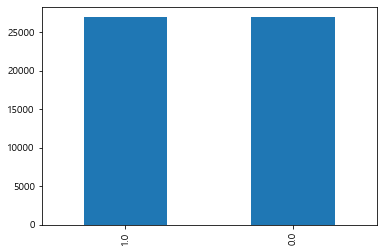

In [ ]:
print(y_resample['부도'].value_counts())
y_resample['부도'].value_counts().plot(kind = 'bar')

In [ ]:
X_resample['부도'] = y_resample['부도']
X_resample['부도'].value_counts()

1.0    26915
0.0    26915
Name: 부도, dtype: int64

In [ ]:
bankrupt_1

,자산총계(요약),유동자산(요약),당좌자산(요약),현금 및 현금성자산(요약),단기투자자산(요약),단기예금(요약),단기매매증권(요약),단기대여금(요약),기타단기투자자산(요약),매출채권(요약),...,PCR(Price cash-flow ratio)(최저),PSR(Price sales ratio)(최고),PSR(Price sales ratio)(최저),기업가치(EV),EBITDA,EBITDA/매출액,EBITDA/금융비용,EBITDA/평균발행주식수,EV/EBITDA,부도
0,28990.0,21169.0,10541.0,4330.0,4552.0,4539.0,1.0,13.0,0.0,786.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
1,20908.0,16359.0,2307.0,1829.0,18.0,0.0,6.0,13.0,0.0,14.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
2,15401.0,9880.0,1436.0,355.0,246.0,240.0,6.0,0.0,0.0,26.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
3,11063.0,8534.0,1083.0,2.0,381.0,380.0,0.0,0.0,1.0,72.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
4,5179.0,3893.0,445.0,11.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27352,79137.0,14794.0,12274.0,1440.0,5065.0,0.0,0.0,0.0,5065.0,5158.0,...,35.62,0.43,0.28,55934.79,1348.52,0.94,10.71,89.90,41.48,1.0
27353,79912.0,15880.0,13124.0,1588.0,5058.0,0.0,0.0,0.0,5058.0,6315.0,...,24.31,0.34,0.24,46036.63,1147.56,0.74,9.02,76.50,40.12,1.0
27354,75206.0,12515.0,11029.0,4017.0,5.0,0.0,0.0,0.0,5.0,4403.0,...,7.82,0.40,0.24,36557.57,1451.79,0.87,16.83,96.79,25.18,1.0
27355,83661.0,22620.0,19701.0,2318.0,11472.0,0.0,0.0,0.0,11472.0,5161.0,...,51.31,0.86,0.25,78081.78,1009.25,0.67,507.93,67.28,77.37,1.0


In [ ]:
from scipy import stats
bankrupt_0 = X_resample.loc[X_resample['부도']==0]
bankrupt_1 = X_resample.loc[X_resample['부도']==1]

ttest = stats.ttest_ind(bankrupt_0, bankrupt_1, equal_var = True)
print("Assuming equal variances : t-value = %.3f, p-value = %.3f" % ttest)

TypeError: only size-1 arrays can be converted to Python scalars

In [ ]:
a,b = stats.ttest_ind(bankrupt_0, bankrupt_1, equal_var = True)

In [ ]:
ttest_result = stats.ttest_ind(bankrupt_0['부도'], bankrupt_1['부도'], equal_var = True)

In [ ]:
ttest_result

Ttest_indResult(statistic=-inf, pvalue=0.0)

In [ ]:
ttest_result = stats.ttest_ind(bankrupt_0, bankrupt_1, equal_var = True)

In [ ]:
ttest_result

Ttest_indResult(statistic=array([-3.04343377e+01, -3.55018995e+01, -3.46198339e+01, -5.04934174e+01,
       -3.59149843e+01, -4.26988701e+01, -1.91795816e+01,  2.85752922e+01,
       -2.26783425e+01, -2.93533866e+01, -1.14334625e+01,  1.05258379e+01,
       -2.32227338e+01, -1.14813639e+01, -2.90325217e+01, -3.44199030e+00,
       -2.16415056e+01, -1.12506957e+01, -1.41030280e+01, -1.48062180e+00,
       -2.20305839e+01, -1.46351254e+01, -2.54045674e+01, -1.41632257e+01,
       -1.92746043e+01, -2.86305944e+01, -1.64892971e+01, -2.08229010e+01,
       -1.04269111e+01, -2.98915889e+00, -3.67842606e+00, -6.45564523e+00,
       -1.17222107e+01, -1.18577947e+01, -1.19312691e+00,  5.02419431e+00,
        1.49446517e+01, -9.04770480e+00,  2.37051218e+01,  1.48961460e+01,
        9.32544550e+00, -1.17867304e+01, -6.88839287e+00, -6.43903713e+00,
       -1.78320815e+01, -8.70940169e+00, -1.00000000e+00, -6.62354932e+01,
        8.92524903e+00,  2.82109951e+01,  5.63829322e-01, -5.64827100e+00,

In [ ]:
pd.DataFrame(b).astype(float)

,0
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
...,...
257,0.836
258,0.000
259,0.176
260,0.002


In [ ]:
t_test = pd.DataFrame([bankrupt_0.columns, a,b,c])

In [ ]:
t_test = t_test.rename(columns = t_test.iloc[0])
t_test = t_test.drop(t_test.index[0])

In [ ]:
, index={'2': 'p-value'} , index={'3': '유의수준'}, 

In [ ]:
t_test.rename(index={1: 't-value'}, inplace=True)
t_test.rename(index={2: 'p-value'}, inplace=True)
t_test.rename(index={3: '유의수준'}, inplace=True)

In [ ]:
t_testT = t_test.T

In [ ]:
t_testT

,t-value,p-value,유의수준
자산총계(요약),-30.43,1.001e-201,True
유동자산(요약),-35.5,6.643e-273,True
당좌자산(요약),-34.62,9.206e-260,True
현금 및 현금성자산(요약),-50.49,0.0,True
단기투자자산(요약),-35.91,3.627e-279,True
...,...,...,...
EBITDA/매출액,0.2068,0.8361,False
EBITDA/금융비용,-4.053,5.062e-05,True
EBITDA/평균발행주식수,-1.353,0.176,False
EV/EBITDA,3.08,0.002074,True


In [ ]:
t_testT[t_testT['유의수준']==False]

,t-value,p-value,유의수준
임대주택자산(요약),-1.481,0.1387,False
이연자산(요약),-1.193,0.2328,False
이연부채(요약),-1.0,0.3173,False
자본조정(요약),0.5638,0.5729,False
*법인세효과(요약),-1.048,0.2948,False
유형자산증가율,-0.5595,0.5758,False
재고자산증가율,-1.061,0.2887,False
매출액영업이익률,-1.242,0.2144,False
자본금영업이익률,0.8172,0.4138,False
자본금순이익률,0.01892,0.9849,False


In [ ]:
pd.options.display.float_format = '{: .4}'.format

array([-3.04343377e+01, -3.55018995e+01, -3.46198339e+01, -5.04934174e+01,
       -3.59149843e+01, -4.26988701e+01, -1.91795816e+01,  2.85752922e+01,
       -2.26783425e+01, -2.93533866e+01, -1.14334625e+01,  1.05258379e+01,
       -2.32227338e+01, -1.14813639e+01, -2.90325217e+01, -3.44199030e+00,
       -2.16415056e+01, -1.12506957e+01, -1.41030280e+01, -1.48062180e+00,
       -2.20305839e+01, -1.46351254e+01, -2.54045674e+01, -1.41632257e+01,
       -1.92746043e+01, -2.86305944e+01, -1.64892971e+01, -2.08229010e+01,
       -1.04269111e+01, -2.98915889e+00, -3.67842606e+00, -6.45564523e+00,
       -1.17222107e+01, -1.18577947e+01, -1.19312691e+00,  5.02419431e+00,
        1.49446517e+01, -9.04770480e+00,  2.37051218e+01,  1.48961460e+01,
        9.32544550e+00, -1.17867304e+01, -6.88839287e+00, -6.43903713e+00,
       -1.78320815e+01, -8.70940169e+00, -1.00000000e+00, -6.62354932e+01,
        8.92524903e+00,  2.82109951e+01,  5.63829322e-01, -5.64827100e+00,
       -1.17430056e+02, -

In [ ]:
b

array([1.00073017e-201, 6.64259074e-273, 9.20591932e-260, 0.00000000e+000,
       3.62717937e-279, 0.00000000e+000, 1.02829975e-081, 2.94513803e-178,
       2.49641171e-113, 6.60974385e-188, 3.08368151e-030, 6.95932114e-026,
       1.03189458e-118, 1.77628484e-030, 6.75307692e-184, 5.77889482e-004,
       2.02099928e-103, 2.47783795e-029, 4.37804439e-045, 1.38713236e-001,
       4.37110377e-107, 2.07775932e-048, 1.53939038e-141, 1.86780328e-045,
       1.66706050e-082, 6.18864587e-179, 6.18297247e-061, 6.42334606e-096,
       1.97593403e-025, 2.79872917e-003, 2.34906145e-004, 1.08672716e-010,
       1.07188055e-031, 2.15172795e-032, 2.32824934e-001, 5.07165284e-007,
       2.13074866e-050, 1.50729564e-019, 1.37703919e-123, 4.39481993e-050,
       1.14556809e-020, 5.00355596e-032, 5.70438892e-012, 1.21243268e-010,
       6.37750626e-071, 3.13968198e-018, 3.17315003e-001, 0.00000000e+000,
       4.58322378e-019, 7.95125699e-174, 5.72872643e-001, 1.62884826e-008,
       0.00000000e+000, 0

In [ ]:
c = b <= 0.05

In [ ]:
c

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False, False,  True,  True,
        True,  True,

In [ ]:
ttest

Ttest_indResult(statistic=array([-3.04343377e+01, -3.55018995e+01, -3.46198339e+01, -5.04934174e+01,
       -3.59149843e+01, -4.26988701e+01, -1.91795816e+01,  2.85752922e+01,
       -2.26783425e+01, -2.93533866e+01, -1.14334625e+01,  1.05258379e+01,
       -2.32227338e+01, -1.14813639e+01, -2.90325217e+01, -3.44199030e+00,
       -2.16415056e+01, -1.12506957e+01, -1.41030280e+01, -1.48062180e+00,
       -2.20305839e+01, -1.46351254e+01, -2.54045674e+01, -1.41632257e+01,
       -1.92746043e+01, -2.86305944e+01, -1.64892971e+01, -2.08229010e+01,
       -1.04269111e+01, -2.98915889e+00, -3.67842606e+00, -6.45564523e+00,
       -1.17222107e+01, -1.18577947e+01, -1.19312691e+00,  5.02419431e+00,
        1.49446517e+01, -9.04770480e+00,  2.37051218e+01,  1.48961460e+01,
        9.32544550e+00, -1.17867304e+01, -6.88839287e+00, -6.43903713e+00,
       -1.78320815e+01, -8.70940169e+00, -1.00000000e+00, -6.62354932e+01,
        8.92524903e+00,  2.82109951e+01,  5.63829322e-01, -5.64827100e+00,